# A survey on modern fully homomorphic encryption
```{math}
\newcommand{\norm}[1]{\left\lvert\left\lvert #1 \right\rvert\right\rvert_\infty}
\newcommand{\abs}[1]{\left\lvert #1 \right\rvert}
\newcommand{\round}[1]{\left\lfloor #1 \right\rceil}
\newcommand{\Z}{\mathbb Z}
\renewcommand{\P}{\mathbb P}
\newcommand{\R}{\mathbb R}
\newcommand{\Q}{\mathbb Q}
\newcommand{\RLWE}{\mathrm{RLWE}}
\newcommand{\RLWEx}{\mathrm{RLWE'}}
\newcommand{\RGSW}{\mathrm{RGSW}}
```

(introduction)=
# Introduction
## Fully homomorphic encryption

Fully homomorphic encryption (FHE) has been a major field of research in the area of cryptography in the recent years.
In a simple notion its objective can be described as performing operations on data, which itself is securely hidden in an encryption (ciphertext).
For this reason, FHE features a broad range of applications, e.g. secure cloud computing.

The two homomorphic operations, which are mainly considered, are additions and multiplications.
This is sufficient, since technically every deterministic algorithm can be expressed by NAND gates.
A NAND gate for two bits $b_1,b_2 \in \{0,1\}$ is defined as $\mathrm{NAND}(b_1,b_2) = 1 - b_1b_2 \in \{0,1\}$ and thus only requires one addition and one multiplication modulo 2.

In general, the modern FHE approach relies on encryptions, which are based on errors.
These errors gradually increase during homomorphic operations and there is a bound in error-size to which extent a correct decryption is still possible.
Therefore we require a procedure of reducing an accumulated error to its initial size (comparable to a "fresh" encryption error), and in doing so, arbitrarily many homomorphic operations (FHE) become achieveable.
Gentry, who published the first FHE scheme in {cite}`gentry-fhe`, named this procedure bootstrapping.

For more (historical) information about FHE see e.g. Section 6.1. in {cite}`a-decade-of-lattice-cryptography`.

## Summary of the thesis

The thesis is organized as follows:

- In the rest of chapter 1, the {ref}`introduction`, we provide notation and implementation details.

- In Chapter 2, {ref}`ring-learning-with-errors`, we explore the framework of the state-of-the-art notion of (RLWE) ciphertexts.
In doing so, we first investigate properties of the ring $R$ and its modular arithmetic variants, which serve as plaintext/ciphertext spaces.
We proceed to define a measure, i.e. $\norm \cdot$, to keep track of the "size" of ring elements, e.g. the errors required for encryptions.
We also thoroughly analyse the probabilistic nature of $\norm \cdot$-bounds during adding/multiplying ring elements, as this later helps us to properly understand error growth in various contexts.
Lastly, we give a decent overview over security terms and definitions connected to the modern ring learning with errors cryptosystems.

- In Chapter 3, {ref}`the-BFV-scheme`, we examine the underlying encoding scheme (published in {cite}`BFV`), which provides algorithms for (secret/public) key-generation, encryption, decryption, addition and multiplication of ciphertexts.
We especially focus on the error growth during the homomorphic operations, since these results heavily influence the overall running time, if one thinks of bootstrapping as an expensive intermission between performing additions/multiplications.
For that matter, we derive a bound for correct decryption and analyse the performance (depending on the choice of parameters) computationally.

- In Chapter 4, {ref}`preparations-for-bootstrapping`, we establish methods to limit the error growth during multiplication, which is mandatory for our bootstrapping algorithm to be functional.
To achieve this, we introduce alterations/extensions of the fundamental RLWE ciphertexts and analyse the corresponding algorithms.
Furthermore, we investigate the two common auxiliary operations automorphism evaluation and rescaling.

- In Chapter 5, {ref}`bootstrapping`, we finally present the core algorithm (published in {cite}`boot`), which itself primarily contains the auxiliary part $\texttt{scaled-mod}$, whose target is the realization of a non-trivial multiplication with a large constant.
Splitting up the latter algorithm into three parts and also splitting up the problem into a large magnitude of subproblems will reveal, why bootstrapping is a computationally costly procedure after all.
We conclude the description of the bootstrapping procedure by adapting it to the employed scheme of encoding, i.e. BFV.
During the entire chapter, we will particularly emphasize on a detailed error discussion, the (optimal) parameter selection and the runtime analysis.
As a proof of concept, we computationally review the bootstrapping scheme by verifying the correctness, inspecting the runtime and rechecking on the parameter selection.
At last, we look into a simple application of fully homomorphic encryption, i.e. how to realize a more complex homomorphic operation, namely integer comparison e.g. used for the evaluation of if-statements.


## Notation
- With $\round \cdot$ (respectively $\lceil \cdot \rceil$ and $\lfloor \cdot \rfloor$) we denote the rounding function to the nearest integer (respectively up/down), which will be extended to polynomials coefficient-wise and to vectors entry-wise.
- Since most of our variables will be of polynomial nature, to avoid confusion we will denote vectors as $\vec v$.
For vectors, we will write the scalar product as $\langle \cdot, \cdot \rangle$.
- Algorithms will be indicated in $\texttt{algorithm}$ textstyle.
The symbol ' will correspond to a $\texttt{x}$ inside algorithms, e.g. $\mathrm{RLWE'}$ becomes $\texttt{rlwe-x}$.
- The abbreviation i.i.d. in the context of random variables stands for "identically and independently distributed".

## Implementation details

The implementation of the bootstrapping scheme relies on the separate Python file "polynomial\_arithmetic.py", which performs polynomial arithmetic and other useful operations on polynomials in {ref}`the-ring-R`. 
The framework of the Python file originates in {cite}`sarojaerabelli`, which has been partly modified and extended.
The main motivation of using it has been the lack of a (simple) Python package, which handles arithmetic of arbitrary long integers as coefficients of polynomials in the above ring.
The Python file includes extensive descriptions of its algorithms.

A main contribution was the implementation of a faster multiplication algorithm, namely the Karatsuba algorithm, which in contrary to the state-of-the-art multiplication techniques is simpler to implement from scratch and most importantly directly applicable to any ciphertext modulus $Q$ and ring degree $N$ (these parameters will be examined in {ref}`the-modular-variant-of-the-ring-R`).
In the original file, i.e. in {cite}`sarojaerabelli`, the modern Fast Fourier Transform (FFT) multiplication algorithm is included, which is considerably faster compared to Karatsuba, but not applicable to powers of two as bootstrapping parameters (e.g. $Q$).
Since powers of two greatly simplify the mathematical analysis of the scheme and furthermore implementing techniques and algorithm speed are not the main concerns of this thesis, we have chosen to omit a FFT implementation.

In general, multiplying efficiently is extremely important, since the bootstrapping procedure bases on multiplications of polynomials.
Apart from handling polynomials in the ring as a class object, we also import auxiliary functions, which generate polynomials, whose coefficients have a certain properties, e.g. being drawn from a specific distribution (see {ref}`background-on-probability-theory`).

Further inspiration for implementing the somewhat homomorphic BFV scheme in Python (see {ref}`the-BFV-scheme`) has been drawn from {cite}`bfv-implementation`.
The full implementation, including an online jupyter book version of the thesis featuring executable code cells, can be found at [https://github.com/robinkoestler/A-survey-on-modern-fully-homomorphic-encryption](https://github.com/robinkoestler/A-survey-on-modern-fully-homomorphic-encryption). 

The bootstrapping implementation, which is split-up among many auxiliary procedures throughout the document, will be analysed in a step by step fashion.

Below we import all necessary external Python packages and the class to handle polynomial arithmetic as $\texttt{Poly}$.
The variable $\texttt{speed}$ linearly controls the running time and it may be augmented to obtain more precise computational results in the case of e.g. probabilistic bounds.

In [1]:
import polynomial_arithmetic, random
from polynomial_arithmetic import *
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from datetime import timedelta
from math import log, floor, ceil, sqrt, gcd, exp, pi, erf
Poly = polynomial_arithmetic.Polynomial # the class of handling polynomial arithmetic in R
speed = 1 # precision factor for computations: Scales the running time.

(ring-learning-with-errors)=
# Ring learning with errors (RLWE)
(the-ring-R)=
## The ring $R$
Our cryptographic scheme will work with polynomials, which are elements of the ring $R := \Z[x]/\langle x^N +1 \rangle$ with a power of two $N > 1$.
We will often refer to the coefficients $c_0,\dots,c_{N-1} \in \Z$ of an element $r(x) \in R$ by using the standard $r(x) = \sum_{i=0}^{N-1} c_i x^i$ representation.

There are many reasons for the choice of $R$:
- First and foremost, in the described scheme we are working within discrete structures (messages, ciphertexts, etc. built on elements of $\Z$).
Thus we have the advantage of the simplicity of representing everything via integers, whereas in approximate cryptographic schemes (like CKKS, where $\R$ or $\mathbb C$ are used, see {cite}`CKKS`) one has to worry about rounding errors during computations, which affect the message precision and so on.
- We are using polynomial rings in general to assure that the basic ring operations (addition and multiplication) can be efficiently calculated by computers without too much effort concerning implementing techniques of the latter. 
- After multiplying two ring elements, we are left to reduce the result modulo $x^N + 1$, which is as simple as a sign change and adding two polynomials in $R$, because $x^N = -1$ in $R$.
Compared to regular polynomial division for arbitrary polynomial quotient rings, this is computationally close to optimal.
- At last, we have the property of having no nonzero zero divisors in $R$, which avoids possible degeneration by performing ring operations:

````{prf:theorem}
:label: R_integral
$R$ is an integral domain.
````

````{prf:proof}
$x^N+1$ is the $2N$-th cyclotomic polynomial.
All cyclotomic polynomials are irreducible over $\Q[x]$ and monic, thus they are irreducible over $\Z[x]$, too.
Because $\Z$ and $\Z[x]$ are both unique factorization domains, $x^N+1 \in \Z[x]$ is a prime element equivalently to being irreducible over $\Z[x]$.
It follows that the ideal $I = \langle x^N +1 \rangle$ is a prime ideal and therefore $R = \Z[x]/I$ is an integral domain.
````

(the-modular-variant-of-the-ring-R)=
## The modular variant of the ring $R$

The above ring $R$ cannot possibly degenerate nonzero elements to zero during ring operations, but nevertheless it contains infinitely many elements - a property we want to avoid while using a similar structure for message/ciphertext spaces.
The introduction of a power of two modulus $M > 1$ to define the finite quotient ring $R_M := R/MR$ resolves this issue and has the following impacts:
- Because of the finiteness, we are now able to choose elements of $R_M$ e.g. uniformly at random.
This will later be necessary to define the "Decision RLWE" problem, on which the security of our scheme is based.
- To uniquely represent the coefficients of a polynomial in $R_M$, we will use the set of integers inside $(-M/2,M/2]$.
Naturally, this is advantageous for two reasons.
    - Firstly, it allows a coefficient to be sampled e.g. from a discrete normal distribution around zero.
    - Secondly, compared to e.g. $[0,M-1]$ it halves the maximum absolute value a polynomial coefficient can reach and therefore is an optimal choice regarding the complexity of algorithms operating on integers.
- By using different power of two moduli as $M$, we can adjust our plaintext/ciphertext/bootstrapping space size to our necessities.
Switching between these will be easily done by just embedding (from small to large modulus) respectively by a modular reduction of the coefficients (vice versa).

To illustrate the use of modular variants of $R$, let us consider a small message space, e.g. $R_8$, and a larger (ciphertext) space, e.g. $R_{32}$, without a further specified $N$.
Technically, we could just trivially embed an example message $2x+1 \in R_8$ into the larger ring as $2x+1 \in R_{32}$.
But since we furthermore need to introduce additive errors, which make our scheme secure and also alter ring elements slightly, we can use a different, more sophisticated embedding into $R_{32}$ than just enlarging the space in general.
For this example consider the ring-dependent expansion factor $\kappa := 32/8 = 4$ and the switching of rings procedure:

```{math}
\underbrace{2x+1}_{\in R_8} \overset{\cdot \kappa}{\dashrightarrow} \underbrace{8x+4}_{\in R_{32}} \overset{+ e }{\dashrightarrow} \underbrace{9x+3}_{\in R_{32}} \overset{: \kappa}{\dashrightarrow} \underbrace{2.25 x + 0.75}_{\in\Q[x]/\langle x^N+1 \rangle} \overset{\round \cdot}{\dashrightarrow} \underbrace{2x+1}_{\in R_8}
```

with an error $e := x-1$.
We observe that instead of irrevokably changing the message by adding $e$ to $2x+1$ in $R_8$, we made use of the larger ring $R_{32}$ in such a way, that it preserves the message when adding $e$ in $R_{32}$ and switching back to $R_8$ afterwards.
This later becomes a crucial idea in the bootstrapping procedure, where errors are "large".
The above procedure also highlights that power of two moduli $M$ generally result in integer $\kappa$'s, which keeps the upscaling by $\kappa$ clean from rounding errors.

To sum it up, we gain security and sizing-control by adding modular arithmetic to $R$.
However, it should be remarked that $R_M$ for powers of two $M>2$ and $N$ is no longer an integer domain.
Hence it is important to keep track of where and when we can reduce a $R$-element modulo $M$, after performing operations favorably in $R$ itself.

## Size and norm of ring elements
The above example of switching (modular) rings points out that it is indeed important to distinguish between "small" and "large" ring elements, refering to the "size" of the coefficients.
This size can be measured by the infinity norm adapted to the rings as follows $\norm{y} := \max \{|y_i| : i \in \{0,\dots,N-1\}\}$, where $y_i$ are the coefficients of $y \in R$.
Note that, if especially $y \in R_M$, this definition already expects the centered reductions $y_i$ modulo $M$.

Additionally, let us remark that in contrary to $R$, $\norm \cdot$ for $R_M$ is not a norm in the classical sense, because it is not compatible with modular arithmetic, e.g.:

```{math}
M = \abs{M/2} \cdot \norm{x+2} \neq \norm{(M/2)(x+2)} = \norm{(M/2)x} = M/2.
```

Nevertheless in $R$ the norm properties are satisfied, and thus we will mainly work with $R$ instead of the modular variant, for which we will only reduce at certain times during our computations.
Moreover later on, our error within ciphertexts must not surpass a certain bound $< M/2$ for correct decryptions, so $\norm \cdot$ will be used to measure the error size.

(background-on-probability-theory)=
## Background on probability theory
### Ocurring distributions
Let us denote the sampling of $y$ from a probability distribution $\mathcal D$ by $y \sim \mathcal D$.
In the same fashion, we say we sample a ring element $y \in R$ from a distribution $\mathcal D$, if we independently and identically sample the related coefficients $y_0, \dots, y_{N-1}$ of $x$ each from $\mathcal D$.

We will use the following distributions for $y \in \Z$:
- Discrete uniform distribution $\mathcal U(a,b)$: For integers $a \le b$ and $i \in \Z \cap [a,b]$ fixed, we have $\mathbb P(y=i) := 1/(b-a+1)$.
Most of the time, we will use $\mathcal U(R_M) := \mathcal U(-M/2,M/2)$.
Notice that technically $-M/2$ is not in the (representative) set $\Z_{M}$, but for sampling we will use it anyway, since otherwise $\mathcal U(R_M)$ would have mean one instead of zero.
The overall effect of this on the uniformity of the distribution is quite negligible while using a (typically) large $M$.
- Discrete centered normal distribution $\mathcal {N}_d(0,\sigma^2)$:
For a (real) standard deviation parameter $\sigma \ge 0$ and $i \in \Z$ fixed, we assign $\mathbb P(y = i) := \int_{i-1/2}^{i+1/2} f_{\mathcal N(0,\sigma^2)}(z) dz$, where $f_{\mathcal N(0,\sigma^2)}$ is the probability density function of the (continuous) normal disribution $\mathcal N(0,\sigma^2)$.
In other words,  while sampling discretely we simply round the values obtained from the continuous distribution to the nearest integer. 
Notice furthermore that $\mathcal N_d(0,\sigma^2)$, although we denote it in the same way, only has mean zero, but it doesn't have variance $\sigma^2$ (see {prf:ref}`discrete-variance`).
- Ternary distribution $\mathrm{Ter}_\rho$: For a parameter $\rho \in (0,1)$ define the ternary distribution by $\mathbb P(y = -1) = \mathbb P(y = 1) = (1-\rho)/2$ and $\mathbb P(y = 0) = \rho$.
In our implementation, we set $\rho$ to $1/3$, thus $\mathrm{Ter}_{1/3} = \mathcal U(-1,1)$.
Another noteable choice: A large $\rho$ leads to samples of sparse ring elements, which have computational advantages.

Efficient bootstrapping relies on a detailed error analysis, whose errors are typically generated from the discrete normal distribution.
Hence we will need to apply theorems from probability theory to estimate the size of an error (with high probability).
Since errors will also be added and multiplied throughout the bootstrapping scheme, we will proceed to analyse the error growth depending on different operations and distributions.

### The error function $\mathrm{erf}$
````{prf:definition} The error function
:label: error-function
For $x \in \R$, the error function $\mathrm{erf}(x)$ is given by:
```{math}
\mathrm{erf}(x) := \frac{2}{\sqrt{\pi}} \int_0^x e^{-t^2}dt
```
````

The error function will be useful to calculate the probability that $\norm y$ for $y\in R$ has a certain bound.

````{prf:property} Properties of $\mathrm{erf}$
:label: property-error-function
Let $F(x)$ be the cumulative distribution function of the normal distribution $\mathcal N(0, \sigma^2)$. Then for a corresponding random variable $X$ we have:
```{math}
\P(\abs X \le x) \overset{\text{if } x > 0}{=} \mathrm{erf}(x/\sqrt{2\sigma^2}) = 2F(x) -1 = F(x) - F(-x)
```
````


### Bounds for the normal distribution
Suppose we sample $y \in R$ from $\mathcal N_d(0,\sigma^2)$ and want to derive a bound on $\norm y$ for further computations.
Naturally, only a probabilistic bound can be achieved here.
Thus we consider the scenario: Determine the small probability $p_{norm}(k)$ for which $\norm y \le k\cdot \sigma$ holds for various $k \in \mathbb N$.

For a single coefficient $y_i \in \Z$ of $y$, we have by definition:

$$
p := \P(\abs{y_i} \le k \cdot \sigma) = \mathrm{erf}\left( \frac{\lfloor k\sigma \rfloor + 1/2}{\sqrt{2}\sigma}\right)
$$

Because the $y_i$ are i.i.d. samples, we have that

```{math}
:label: bernoulli-estimation
    p_{norm}(k) = \P(\norm y \le k \cdot \sigma) = p^N \ge 1 - N (1-p)
```

using the maximum inside $\norm \cdot$ and Bernoulli's inequality.


````{prf:theorem} Norm bounds for standard Gaussian sampling in $R$
:label: sampling-bound

For an $R$-element $y \sim \mathcal N_d(0,\sigma^2)$ with $\sigma \ge 1$, we can assume the bound $\norm y \le k\sigma$ with probability $\ge \mathrm{erf}\left( (k-1)/\sqrt{2} \right)^N$.
````
````{prf:proof}
Following the above discussion, all left to show is the bound of $\mathrm{erf}$. This follows because $\mathrm{erf}$ is strictly increasing and thus estimating $(\lfloor k \sigma \rfloor + 1/2)/\sigma \ge (k-1)$ with $\sigma \ge 1$ yields the result.
````

We now want to determine pairs $(k,p_{norm}(k))$ computationally by using the Bernoulli estimation given in {eq}`bernoulli-estimation`, because of precision issues during exponentiation.
For simplicity, we also set $\sigma = 1$, since it has an negligible effect on the result anyway.

In [2]:
N = 10**4
for k in range(3,9):
    p = erf((k+0.5)/sqrt(2))
    print(f"k = {k} leads to 1-{N}*(1-p) = {1-N*(1-p)}")

k = 3 leads to 1-10000*(1-p) = -3.6525815807108017
k = 4 leads to 1-10000*(1-p) = 0.9320465375052258
k = 5 leads to 1-10000*(1-p) = 0.9996202087504393
k = 6 leads to 1-10000*(1-p) = 0.999999196800271
k = 7 leads to 1-10000*(1-p) = 0.9999999993616218
k = 8 leads to 1-10000*(1-p) = 1.0


Computational conclusion: Later we will set the parameter $N$ to around $10^4$.
Hence, with e.g. using $k=10$, our computations let us surmise that $\norm{y} > 10\sigma$ only happens with probability $\approx 10^{-18}$.
Other authors regularly assume a lower $k$, e.g. $k=6$, implying a probability of bound-exceeding around $10^{-6}$ per sample.
This is also reasonable, since the norm-wise equilibrating effects of adding/multiplying elements of $R$ respectively $R_M$, which we will soon discuss in detail, will take care of the outliers anyway.

### Bound for adding two $R$-elements
Let $x_1,\dots,x_m \in \R$ be independently sampled from $\mathcal N(0,\sigma^2)$.
It is widely known that $\sum_{i=1}^m x_i$ has then the distribution $\mathcal N(0,m\sigma^2)$.
That is, because the sum of variants equals the variance of the sum, in the independently random variables case (Bienaymé's identity).
To bound $\norm{y+z}$ for $y,z \in R$ and $y,z \sim \mathcal N_d(0,\sigma^2)$, we therefore have to determine the variance of the distribution $\mathcal N_d(0,\sigma^2)$.
````{prf:lemma} Variance of rounded centered normal distributions
:label: discrete-variance
For $\sigma \ge 1$ and a random variable $X\sim \mathcal N_d(0,\sigma^2)$, we have:
```{math}
\mathrm{Var}(X) \le \sigma^2 + \frac{1}{12}.
```
````

````{prf:proof}
We will use the result from Equation 3.2. in {cite}`discrete-variance`, which treats our case for $a=0$.
For a more detailed derivation of a proof of this equation, we refer to {cite}`discrete-variance-proof`.
Following these papers, we have:
```{math}
\mathrm{Var}(X) = \sigma^2 + \frac{1}{12} + 4 \sum_{k=1}^\infty (-1)^k e^{-2k^2\pi^2\sigma^2} \cdot (\sigma^2 + (2\pi k)^{-2}).
```
If we denote by $a_k$ the sequence in the above series, notice that $\abs{a_k}$ is strictly decreasing for $\sigma \ge 1$.
Because $a_k$ is alternating in sign, starting with $-1$, we verify our bound $\sigma^2 + 1/12$ by just ignoring the series in general, since the value of the series will be negative:
```{math}
\sum_{k=1}^\infty a_k = a_1 + \sum_{k=2}^\infty a_k \le a_1 + a_2 < 0.
```
````



In practice, the above result  could even hold for $\sigma \ge 0.3$, which the computation below points out.

In [3]:
def cdf(x, sigma): # cumulative density function for N(0, sigma^2)
    return (erf(x/sqrt(2*(sigma**2)))+1)/2
sigma = 0.3 # test with 0.1, 0.3, 1
var_values = [(i**2)* (cdf(i+0.5,sigma) - cdf(i-0.5,sigma)) for i in range(-1000,1000+1)]
print(f"With sigma = {sigma}, the bound of 1/12 is instead approximately 1/{1/(sum(var_values) - sigma**2)}")

With sigma = 0.3, the bound of 1/12 is instead approximately 1/179.13363773216952


Putting everything together, we end up with:
````{prf:theorem} Norm bound for adding $R$-elements
:label: norm-bound-adding_R
Let $x_1,\dots,x_m \in R$ be independently sampled from $\mathcal N_d(0,\sigma^2)$ and $y = x_1+\dots+x_m$. Then we can assume the bound $\norm y \le k\sigma \sqrt{m}$ with an approximate probability of
```{math}
\mathrm{erf}\left( \frac{k\sigma}{\sqrt{2\cdot(\sigma^2+1/12)}} \right)^N \approx \mathrm{erf}(k/\sqrt{2})^N
```
for $k \in \mathbb N$ and large $m$. 
````
````{prf:proof}
We prove the theorem in the same fashion as {prf:ref}`sampling-bound`, by treating each coefficient $c$ of $y \in R$ individually and later using {eq}`bernoulli-estimation` to analogously generalize for the ring element $y$.
So let $c$ be the sum of $z_1,\dots,z_m \in \Z$ independently sampled from $\mathcal N_d(0,\sigma^2)$.
By Bienaymé's identity and the independency of the $z_i$, the variance of $c$ can be bound by $m\sigma^2 +m/12$ using {prf:ref}`discrete-variance`.

It is now reasonable to assume that $c \sim \mathcal N(0,m\sigma^2 +m/12)$ in an approximate way, since the $z_i$ themselves come from a slightly altered normal distribution.
This argument is supported by the central limit theorem, which yields the exact same distribution $\mathcal N(0,m\sigma^2 +m/12)$ as an approximation for large $m$, if one takes the sequence $(z_i) \sim \mathcal N_d(0,\sigma^2)$ as as input.

We compute using {prf:ref}`property-error-function`:
```{math}
\P(\abs c > k\sqrt{m}\sigma) \approx \mathrm{erf}\left( \frac{k\sigma\sqrt{m}}{\sqrt{2\cdot(m\sigma^2+m/12)}} \right).
```
where $\sqrt{m}$ cancels out.
Furthermore, the term "$+1/12$" coming from {prf:ref}`discrete-variance` is more of theoretical interest, since it only has a marginal influence on the probability bound.
If we choose to omit it, also $\sigma$ cancels out, which leaves us with the second approximation.
````

Let us give a quick demonstration of the bound given in the theorem.
Taking $N=1$ for simplicity, $m=3$ for adding three $R$-elements, $\sigma = 1$ to have a rounding effect and $k=3$ for not having to do too many iterations:

In [4]:
m, sigma, iterations, k, counter = 3, 1, 5000*speed, 3, 0
# below: without "+1/12" the approximation sometimes exceeds the ratio
p = erf((k*sigma) / sqrt(2 * (sigma**2+1/12)))
for _ in range(iterations):
    y = sum([generate_gaussian_distribution(1,0,sigma).evaluate(1) for _ in range(m)])
    if abs(y) <= k * sqrt(m) * sigma:
        counter += 1
print(f"{counter} out of {iterations} y's satisfying the bound (= ratio of {counter/iterations})")
print(f"Probability approximation given in theorem = {1-1*(1-p)}")

4989 out of 5000 y's satisfying the bound (= ratio of 0.9978)
Probability approximation given in theorem = 0.9960522481430966


(bound_for_multiplying_two_ring_elements)=
### Bound for multiplying two $R$-elements
Similarly to adding $R$-elements $y,z$, we want now to derive a bound on $\norm{y \cdot z}$ depending on $\norm y$ and $\norm z$.
The worst-case can be estimated as $\norm{y \cdot z} \le N \cdot \norm{y} \norm{z}$ and this bound is tight (e.g. for $y = z := \sum_{i=0}^{N-1} x^i$).

#### The case "uniform" times "ternary"
The objective of this section is now to improve this bound for the average case of multiplying an $R$-element $y \sim \mathcal U(R_Q)$ times an $R$-element $z \sim \mathrm{Ter}_\rho$.
Recall the formula for calculating the coefficients of the product $yz$ in the ring $R$:

$$
(yz)_i := \sum_{j=0}^i y_iz_{i-j} + \sum_{j=i+1}^{N-1} -y_i z_{i+N-j}
$$

````{prf:lemma}
:label: uniform-times-ternary
Let $Y \sim \mathcal U (-Q/2,Q/2)$ and $Z \sim \mathrm{Ter}_\rho$ be independent integer random variables for $\rho \in (0,1)$. Then $YZ$ and $-YZ$ have mean zero and variance $(1-\rho) \cdot \mathrm{Var}(Y)$.
````
````{prf:proof}
Because of the independency, we have $\mathbb E[YZ] = \mathbb E[Y]  \mathbb E[Z] = 0$.
The variance of $Z$ is $1-\rho$, and then again due to the independency $\mathrm{Var}(YZ) = (1-\rho)\mathrm{Var}(Y)$.
Since also $Z \sim -Z$ holds, the claim follows.
````

We can now again use the Central Limit Theorem to approximate the distribution of our multiplied coefficient $(yz)_i$.
So we have:

```{math}
:label: central-limit-approx
\P\left( \abs{(yz)_i} \le \sqrt{N \cdot \mathrm{Var}(y_iz_i)} \cdot v \right) \approx \Phi(v) - \Phi(-v) = \mathrm{erf}(v/\sqrt{2})
```

where $\Phi$ is the cumulative density function of $\mathcal N(0,1)$.

In the literature, often the bound $\norm{yz} \le C \sqrt{N} \norm y \le C \sqrt{N} (Q/2)$ is found for our case of $y$ and $z$.
Heuristic experiments for choices of $C$ underline that usually $C$ ranges in $[1,2]$.
Such experiments have been conducted in e.g. Section 6.1. in {cite}`heuristic-multiplication-bound`.
We may now formulate a theorem, where we estimate the probability that the bound is satisfied for $C$ using the above.

````{prf:theorem} Norm bound for multiplying uniform times ternary in $R$
:label: multiplication-bound-uniform-ternary
For $R$-elements $y \sim \mathcal U(R_Q)$ and $z \sim \mathrm{Ter}_{\rho}$, we have $\norm{yz} \le C\sqrt{N}\norm{y}\norm{z}$ with probability approximately:
```{math}
\mathrm{erf}\left(\frac{C\sqrt{6}\norm y}{\sqrt{1-\rho}\cdot Q}\right)^N \overset{\rho = 1/3}{\approx} \mathrm{erf}(3C)^N.
```
````

````{prf:proof}
Using the central limit theorem as in {eq}`central-limit-approx` and {prf:ref}`uniform-times-ternary` we have:
```{math}
\P(\abs{(yz)_i} \le C\sqrt{N}\norm y) \approx \mathrm{erf} \left( \frac{C\norm y}{\sqrt{2\cdot \mathrm{Var}(y_iz_i)}}\right) = \mathrm{erf} \left( \frac{C\norm y}{\sqrt{2(1-\rho)\mathrm{Var}(y_i)}}\right).
```
For the uniform distribution we have $\mathrm{Var}(y_i) = ((Q+1)^2-1)/12$.
Now $\sqrt{\mathrm{Var}(y_i)} \approx Q/\sqrt{12}$ is very accurate for large $Q$.

Finally, we estimate $\P(\norm{yz} \le C\sqrt{N}\norm y) \approx \P(\abs{(yz)_i} \le C\sqrt N \norm y)^N$ and the claim follows.
Only an approximation is accurate in this case, since $(yz)_i$ and $(yz)_j$ for $i\neq j$ are not statistically independent anymore.
The reason is that:
```{math}
\P(y_iz_i =  y_i z_j) = \P(z_i = z_j) = \rho^2 + (1/2) \cdot (1-\rho)^2 \overset{\rho = 1/3}{=} 1/3.
```
In total, one summand inside $(yz)_i$ and $(yz)_j$ is equal with probability $1/3$, and $k$ summands are equal with probability $(1/3)^k$ (for $\rho = 1/3$).
Nevertheless we assume independency of the family $((yz)_i)_{i \in \{0,\dots,N-1\}}$ anyway, since this effect becomes negligible for large $N$ (even though we have $N-1$ choices for $j$ in $(yz)_j$ to compare with a fixed $(yz)_i$).  
````

The above probability is largely dependent on the size of $\norm y$ and $C$.
Since $y$ contains uniformly sampled coefficients, $\norm y$ is regularly about the size of $Q/2$.
For example:

$$
\P\left(\norm y \ge \frac{Q}{2}-\frac{Q}{2}\frac{1}{N}\right) = 1 - \P\left(\abs {y_0} < \frac{Q}{2}-\frac{Q}{2}\frac{1}{N}\right)^N = 1 - \left(\frac{Q-Q/N}{Q}\right)^N \approx 1 - e^{-1} \ge 0.63
$$

A demonstration of the value in {prf:ref}`multiplication-bound-uniform-ternary` in practice (notice that for $C=2$ the bound gets exceeded with probability around $0.002$):

In [5]:
Q, N, C, counter, iterations = 2**10, 2**6, 2, 0, 1000*speed
for i in range(iterations):
    y = generate_uniform_distribution(N, -Q/2, Q/2)
    z = generate_ternary_distribution(N) # rho = 1/3
    if y.multiply(z).norm() <= C*sqrt(N)*y.norm():
        counter += 1
print(f"{counter} out of {iterations} satisfied bound (ratio {counter/iterations})")
norm_average = sum([generate_uniform_distribution(N, -Q/2, Q/2).norm() for _ in range(iterations)]) // iterations
print(f"Probability in theorem {erf(norm_average*C*3/Q)**N}")

994 out of 1000 satisfied bound (ratio 0.994)
Probability in theorem 0.9981059300560312


#### The case "Gaussian" times "ternary"
Essentially, we can transform our analysis from the previous section to this case.
So, let $R$-elements $y,z$ be sampled as $y \sim \mathcal N_d(0,\sigma^2)$, $z \sim \mathrm{Ter}_\rho$ for $\sigma \ge 1$.
Now, using the argument in {prf:ref}`uniform-times-ternary` and the value of {prf:ref}`discrete-variance`, we have for integer random variables $Y \sim \mathcal N_d(0,\sigma^2)$ and $Z \sim \mathrm{Ter}_\rho$:

$$
\mathrm{Var}(YZ) = (\sigma^2 + 1/12)(1-\rho)
$$

````{prf:theorem} Norm bound for multiplying Gaussian times ternary in $R$
:label: multiplication-bound-gaussian-ternary
For $R$-elements $y \sim \mathcal N_d(0,\sigma^2)$ and $z \sim \mathrm{Ter}_{\rho}$, we have $\norm{yz} \le C\sqrt{N}\norm{y}$ with probability approximately:
```{math}
\mathrm{erf} \left( \frac{C\norm y}{\sqrt{2(1-\rho)(\sigma^2+1/12)}}\right)^N \overset{\rho = 1/3}{\approx} \mathrm{erf}(\sqrt{3}C)^N.
```
````

````{prf:proof}
The proof works as the proof of {prf:ref}`multiplication-bound-uniform-ternary`.
Using the central limit theorem as in {eq}`central-limit-approx` and {prf:ref}`uniform-times-ternary` once again, we have:
```{math}
\P(\abs{(yz)_i} \le C\sqrt{N}\norm y) \approx \mathrm{erf} \left( \frac{C\norm y }{\sqrt{2\cdot \mathrm{Var}(y_iz_i)}}\right) = \mathrm{erf} \left( \frac{C\norm y}{\sqrt{2(1-\rho)(\sigma^2+1/12)}}\right).
```
Now the exact value inside $\mathrm{erf}(\cdot)$ is largely dependent on $\norm y$ and thus on $N$ itself.
For a detailed analysis of $\norm y$, it is important to consider {prf:ref}`sampling-bound` for a fixed $N$ to obtain a better probability estimation, but for simplicity it is reasonable to assume that $\norm y \ge 2\sigma$, which regularly already holds for quite small $N$.
Furthermore, we have used {prf:ref}`discrete-variance` for the variance estimation, whose square root is roughly $\sigma$.
````

Remark: If $N \ge 2^{10}$, then $\norm y \ge 3\sigma$ with high probability.
In this case the factor inside $\mathrm{erf}(\cdot)$ is already close to the one in {prf:ref}`multiplication-bound-uniform-ternary`.

Once more we want to illustrate our result by checking computationally, if the bound in the theorem is indeed satisfied.
To not get caught up in precision errors regarding $\norm y$, we only will check on samples with a given norm, e.g. $3\sigma$.

In [6]:
N, sigma, C, counter, iterations = 2**6, 3, 1, 0, 5000*speed
y_norm = round(3*sigma)
for i in range(iterations):
    y = generate_gaussian_distribution(N, 0, sigma)
    while y.norm() != y_norm:
        y = generate_gaussian_distribution(N, 0, sigma)
    z = generate_ternary_distribution(N)
    if y.multiply(z).norm() <= C*sqrt(N)*y_norm:
        counter += 1
print(f"{counter} out of {iterations} satisfied bound (ratio {counter/iterations})")
probability = erf( (C*y_norm) / sqrt((4/3) * ((sigma**2) + (1/12))) )**N
print(f"Probability in theorem {probability}")

4865 out of 5000 satisfied bound (ratio 0.973)
Probability in theorem 0.9838201795058529


(conclusion-on-delta_R)=
#### Conclusion on the expansion factor
Our results on the multiplicative norm-bound in the ring $R$ with the general estimation

```{math}
\norm{ab} \le \delta_R \norm a \norm b
```

let us conjecture that $\delta_R$ is approximately $\sqrt{N}$ (and not $N$) in special cases.
The two above theorems regarding $\delta_R \approx \sqrt{N}$ mainly hold, because $a$ and $b$'s coefficients were i.i.d. samples with mean zero (as e.g. in {prf:ref}`uniform-times-ternary`), which is decisive for the application of the central limit theorem.
We will commonly use the distributions $\mathrm{Ter}_{1/3}, \mathcal U(R_Q)$ and $\mathcal N_d(0,\sigma^2)$ (all with mean zero) for generating elements within our cryptographic constructions.
Almost all variables used later, except for predetermined messages, will thus satisfy the $\delta_R := \sqrt{N}$ constraint.
Therefore we treat the rare case as $\delta_R' := N$ and use $\delta_R$ respectively $\delta_R'$ for our error analysis.

(security)=
## Security
### The Decision-RLWE problem
In this section we provide the details regarding the security of encryption schemes, whose ciphertexts are based on $R$ and its "Learning with errors" problem ($R$-LWE).
An extensive overview over the whole topic is given in {cite}`a-decade-of-lattice-cryptography`, especially Section 4.4, to which we refer as a source for the following definitions.

As a first step we define the RLWE distribution according to Definition 4.4.1. in {cite}`a-decade-of-lattice-cryptography`, which already contains the necessary structure for later defining RLWE ciphertexts.
````{prf:definition} RLWE distribution
:label: RLWE-distribution
For a fixed (secret key) $s \in R_Q$ and a preselected error distribution $\chi$, we say that $(a,b) \in R_Q^2$ is sampled from the RLWE distribution $A_{s,\chi}$, if:
```{math}
(a,b) := (a, -a\cdot s + e), \qquad a \sim \mathcal U(R_Q), e \sim \chi.
```
````

Following up, we assign a problem to the RLWE distribution, which an cryptographic adversary technically has to solve for "learning" information about the distribution (i.e. $s$) despite dealing "with errors" $e$.

````{prf:definition} Decision-RLWE problem
:label: decision-RLWE
Determine (with an non-negligible advantage) for $n$ given i.i.d. samples $(a_i,b_i) \in R_Q^2$, whether they are either sampled from $A_{s,\chi}$ (with $s \sim \mathcal U(R_Q)$) or from $U(R_Q)^2$.
````

Naturally, here we are only allowed to work with a quite small number (typically polynomial in the ring degree $N$) of samples, to prevent the problem from becoming too easy.

Generally speaking, the security reductions, which reduce the Decision-RLWE problem to a well-known problem over lattices, are cumbersome to formulate precisely and difficult to prove.
Thus, these kind of security discussions are an extensive topic on their own, and the variety among the security principles would be too ambitious to break down.
Therefore, later in {ref}`remarks-on-security`, we will only collect some selected remarks about RLWE-distributed ciphertext security, which are particularly important for constructing an efficient fully homomorphic encryption scheme.
But first, let us formulate the security reduction, which requires a quick {ref}`background-on-lattices`. 

```{prf:property} Security reduction from Decision-RLWE to $\mathrm{SVP}_\gamma$
:label: RLWE-security
As mentioned in Theorem 4.4.3. of {cite}`a-decade-of-lattice-cryptography`, the Decision-RLWE problem with proper parameters is at least as hard as quantumly solving the $\gamma$-Approximate Shortest Vector Problem ($\mathrm{SVP}_\gamma$) over ideal lattices.
```

(background-on-lattices)=
### Background on lattices
Given a "lattice basis" $B = \{\vec{b_1},\dots,\vec{b_n}\}$ of linearly independent vectors $\vec{b_i} \in \R^n$, define the corresponding (full-rank) lattice as:
```{math}
\mathcal L := \mathcal L(B) := \left\{\sum_{i=1}^n z_i\vec{b_i} \mid z_i \in \Z \right\}.
```
Let moreover $\lambda_1 := \min_{0 \neq \vec v \in \mathcal L} \lvert\lvert \vec v \rvert\rvert$ denote the length of the shortest non-zero vector in $\mathcal L$ with respect to a norm (usually the euclidean norm in $\R^n$).

Ideal lattices now have the additional property of corresponding to ideals $I$ of the ring $R$.
In this connection it is very important, which embedding from generators (polynomials) of $I$ to generators (integer vectors) of $\mathcal L \subset \Z^N$ is chosen.
For example, one can choose the straightforward coefficient embedding and set
```{math}
\mathcal L(I) = \left\langle(g_0,\dots,g_{N-1}) \mid g = \sum_{i=0}^{N-1} g_i x^i \in I \right\rangle \subset \Z^N.
```
It is clear from the description that $\mathcal L(I) \subset \Z^N$ is isomorphic to $I \subset R$ as an additive group.
This fact illustrates the close relationship between the ring $R$ and ideal lattices and puts the above security reduction from RLWE to lattice problems into context.
Nevertheless, there is a lot more to state about more sophisticated embeddings (see Section 4.3.3. of {cite}`a-decade-of-lattice-cryptography`), which feature more favorable qualities and play a crucial role in the proof of the security reduction of RLWE.

The following definition refers directly to Definition 2.2.2 in {cite}`a-decade-of-lattice-cryptography`.

```{prf:definition} Approximate Shortest Vector Problem $\mathrm{SVP}_\gamma$
:label: approximate-shortest-vector-problem
Given a (full-rank) lattice basis $B$ of an $n$-dimensional lattice $\mathcal L(B)$, find a $0 \neq \vec v \in \mathcal L$ with $\norm {\vec v} \le \gamma(n) \cdot \lambda_1$.
```
Notice that, if $\gamma = 1$, we obtain the special case of the (absolute) Shortest Vector Problem (SVP).

```{admonition} Conjectured (quantum) NP-hardness of $\mathrm{SVP}_\gamma$
In {prf:ref}`RLWE-security`, $\gamma(n)$ is a polynomial function in $n$.
As pointed out in Section 4.3.4 of {cite}`a-decade-of-lattice-cryptography`, such a $\gamma$ still results in an exponential (in $n$) running time for the best known (quantum) algorithms to solve $\mathrm{SVP}_\gamma$ on ideal lattices.
```

(remarks-on-security)=
### Remarks on the security framework for FHE

The following remarks tackle the requirements of {prf:ref}`decision-RLWE`, which need to be partly altered to serve as an efficient framework for FHE:

1. The error distribution (in our case this will be $\mathcal N_d(0,\sigma^2)$) must be chosen carefully. Informally speaking, a larger standard deviation $\sigma$ corresponds to a smaller $\gamma$, which then makes $\mathrm{SVP}_\gamma$ harder. In contrast to that, we are also interested in keeping the error size (thus $\sigma$) very small, to perform more homomorphic operations in a row without needing to perform a costly bootstrapping operation in between.
2. It is important to note, that in {cite}`hardness-for-any-modulus` it has been proven that the security of Decision-RLWE does not rely on specific number theoretical properties of the modulus $Q$ and hence we conveniently can set $Q$ to be a large power of two.
3. Additionally, it is obstructive for our bootstrapping method to use a secret key $s$ sampled from $\mathcal U(R_Q)$. It can be shown that we even may assume $s \sim \chi$ without changing the above theorem (see Section 4.4.1 in {cite}`a-decade-of-lattice-cryptography`). Still, for practical purposes, where we need to realize a distinction of cases (the cases being the values a $s$-coefficient can take), the ternary distribution comes into play. This choice is a compromise, since there is a lack of security proofs for a ternary secret key $s \sim \mathrm{Ter}_\rho$ and moreover sparse ternary keys (with $\rho$ close to $0$) are subject of security concerns. More information can be found in Chapter 1 of {cite}`ternary-secret-keys`. To mention one last argument in favor of using them, ternary secret keys are part of the Homomorphic Encryption Standardization document {cite}`HomomorphicEncryptionSecurityStandard`.


(the-BFV-scheme)=
# The BFV scheme
Before working on a bootstrapping algorithm for achieving fully homomorphic encryption, we need to set the framework of our scheme.
This will be done by considering a somewhat homomorphic encryption scheme, which enables us to encrypt, decrypt and already perform a limited amount of additions and multiplications on a ciphertext.
Notice that for a ciphertext structure as in {prf:ref}`RLWE-distribution` we outlined a proof of security earlier.
Taking that as a foundation, all is left to specify on where and how to hide a message within a ciphertext, which will be the salient feature of BFV ciphertexts.
The BFV (abbreviation of the names of the authors) scheme was initially published in {cite}`BFV`, which will be our main reference throughout this chapter.

## Asymmetric key generation
To start defining our scheme, we solely could contemplate ciphertexts, which only make use of a secret key for encrypting messages.
However, extending the idea to an asymmetric encrypting scheme by introducing a public key can be achieved in a straightforward way.
That is due to the fact that a public key, which is in fact generated from the secret key, simply has a structure identical to any other ciphertext, i.e. a structure as in {prf:ref}`RLWE-distribution`.
It follows that the security reductions for any ciphertext ({prf:ref}`RLWE-security`) also apply for the public key, whose exposure to any party is therefore unproblematic and of great avail.

### Description of the key generation
BFV's $\texttt{keygen}$ algorithm takes as an input a ring degree $N$, a ciphertext modulus $Q$ and a standard deviation $\sigma \ge 0$.
It outputs a public key $\mathrm{pk} \in R_Q^2$ and a secret key $\mathrm{sk} \in R_Q$. It sets:
```{math}
\mathrm{sk} := s \sim \mathrm{Ter}_{1/3}, \qquad
\mathrm{pk} := (\mathrm{pk}_0, \mathrm{pk}_1) := (\mathrm{pk}_0,-\mathrm{pk}_0\cdot s-e)
```
with $\mathrm{pk}_0 \sim \mathcal U(R_Q)$ and an error $e \sim \mathcal N_d(0,\sigma^2)$.

Notice that we can control our error distribution with the parameter standard deviation $\sigma \ge 0$.
As pointed out in {ref}`remarks-on-security`, it is very important to choose the parameters carefully for preserving security hardness results.
Nevertheless, as we will later see, $\sigma$ does not affect the number of possible homomorphic operations greatly.
Hence we conveniently set $\sigma = 1$ while testing our implementations.

In [7]:
def keygen(key_size, ciphertext_modulus, standard_deviation):
    N, Q, STD = key_size, ciphertext_modulus, standard_deviation
    sk = generate_ternary_distribution(N)
    pk_0 = generate_uniform_distribution(N, 0, Q-1)
    e = generate_gaussian_distribution(N, 0, STD)
    pk_1 = pk_0.multiply(sk).add(e).scalar_multiply(-1, Q)
    return [sk, [pk_0, pk_1]]

## Encryption
### Notion of BFV ciphertexts
For encryption we take a previously into the polynomial $M \in R_T$ encoded message, with the coefficients lying in $\mathbb{Z}_T$, where $T$ is the plaintext modulus.
Encryption now essentially uses the public key to transform $M$ into a ciphertext $\mathrm{ct} \in R_Q^2$ defined as:

$$\begin{split}
\mathrm{ct} := (\mathrm{ct}_0, \mathrm{ct}_1) := (z\cdot \mathrm{pk}_0+e_0,z\cdot \mathrm{pk}_1 + e_1 + \lfloor Q/T \rceil M) \in R_Q^2
\end{split}$$

where $e_0, e_1, z \sim \mathcal N_d(0, \sigma^2)$.
To highlight the technique of encryption, we commonly will denote $\mathrm{ct}$ as $\mathrm{BFV}_{Q,s}(M)$.

Notice that the BFV ciphertext as well fits the structure of a RLWE ciphertext as in {prf:ref}`RLWE-distribution`.
That is because $\mathrm{ct}_0$ still looks as uniformly at random, since multiplying with $z$ and adding $e_0$ does not change this in a meaningful way.
Furthermore, the second component containing the hidden secret key as $- \mathrm{pk}_0 \cdot s$ and the error term $-z \cdot e + e_1 - e_0\cdot s$ (which is slightly altered compared to an error generated from $\mathcal N_d(0,\sigma^2)$) can be shown to greatly resemble the structure of a RLWE ciphertext.
More details on the security of $\mathrm{ct}$ are given in Section 8.2 of {cite}`A-Toolkit-for-RLWE`.

The scaling of the message $M$ by the large factor $\round{Q/T}$ is also crucial, since we need to distinguish it from the error during decrypting.

Remarks:
- For constructing something "cryptographically secure", we want to blow up a (rather small) plaintext space $R_T$ to a large ciphertext space $R_Q$, hence we ought to choose $Q$ much larger than $T$.
This is also indispensable for realizing even the simplest operations on ciphertexts, not to mention decrypting.
- For our purposes, we will only use powers of two for $T$ and $Q$, such that the rounding of $Q/T$ is technically obsolete, but nevertheless it should be mentioned as the scheme can be varied to arbitrary $T, Q$ and the above is the usual BFV encryption formula.

In [8]:
def encrypt(message, plaintext_modulus, ciphertext_modulus, standard_deviation, public_key): 
    M, T, Q, STD, pk = message, plaintext_modulus, ciphertext_modulus, standard_deviation, public_key
    N = getattr(message, 'ring_degree')
    z = generate_gaussian_distribution(N, 0, STD) 
    e_0 = generate_gaussian_distribution(N, 0, STD)
    e_1 = generate_gaussian_distribution(N, 0, STD)  
    ct_0 = z.multiply(pk[0]).add(e_0, Q)
    ct_1 = z.multiply(pk[1]).add(M.scalar_multiply(Q // T)).add(e_1, Q)
    return [ct_0, ct_1]

A short demonstration of encrypting:

In [9]:
N = print_and_return("Polynomial ring degree N", 2**2)
T = print_and_return("Plaintext modulus T", 2**2)
Q = print_and_return("Ciphertext modulus Q", 2**20)
STD = print_and_return("Standard deviation STD", 1)
M = print_and_return("\nMessage: M", generate_uniform_distribution(N, 0, T-1))
SK, PK = keygen(N, Q, STD)
encryption = encrypt(M, T, Q, STD, PK)
print("Encryption components are", encryption[0], "\nand", encryption[1])

Polynomial ring degree N = 4
Plaintext modulus T = 4
Ciphertext modulus Q = 1048576
Standard deviation STD = 1

Message: M = x^2 + x + 2
Encryption components are 498928x^3 + 457327x^2 + 426551x + 980296 
and 30778x^3 + 756973x^2 + 692788x + 482687


### Error after BFV encryption
````{prf:lemma} Error after BFV-Encryption
:label: error-after-BFV-encryption
The error size within a BFV-ciphertext after BFV-encryption using $\sigma = 1$ can be estimated as $C\sqrt{N}$. It holds that $C \approx 100$ with high probability.
````
````{prf:proof}
The error after BFV encryption is precisely $-z \cdot e + e_1 + e_0 \cdot s$ with $z,e,e_0,e_1 \sim \mathcal N_d(0,1)$ and $s \sim \mathrm{Ter}_{1/3}$.
Now, many details for determining the norm of multiplied ring elements generated from certain distributions can be examined.
But as the theoretical and computational conclusions in {ref}`conclusion-on-delta_R` suggest, we may use the reasonable estimation:

```{math}
\norm{x_1x_2} \le \sqrt{N}\norm{x_1}\norm{x_2}
```
for $x_1,x_2 \sim \mathcal N_d(0,1)$.

Coming back to the analysis, for a $\mathcal N_d(0,1)$ element $x$, we have $\norm x \le 7$ with overwhelming probability (see {prf:ref}`sampling-bound`).
In total, we may estimate the error after BFV-encryption as:
```{math}
\le 2 \cdot \sqrt{N} \cdot 7^2 + 7 \approx C \sqrt{N}.
```
````

In practice, $C$ is indeed much smaller as the following computation points out.

In [10]:
N, iterations, max_norm = 2**4, 1000*speed, 0
for i in range(iterations):
    a = [generate_gaussian_distribution(N, 0, 1) for _ in range(4)]
    s = generate_ternary_distribution(N)
    max_norm = max(a[0].multiply(a[1]).add(a[2].multiply(s)).add(a[3]).mod_small(Q).norm(), max_norm)
print(f"Maximum C after {iterations} iterations was {max_norm/sqrt(N)}")

Maximum C after 1000 iterations was 6.0


## Decryption
The decryption algorithm takes a BFV ciphertext $\mathrm{BFV}_{Q,\mathrm{sk}}(M) = \mathrm{ct} \in R_Q$ and the secret key $\mathrm{sk}$ as an input and it outputs the hidden message polynomial $M \in R_T$.
To begin with, it eliminates the random component inside a ciphertext by computing:

$$
T\cdot (\mathrm{ct}_0 \cdot \mathrm{sk} + \mathrm{ct}_1)
$$

It is crucial to perform this computation entirely in $R$, that means without modular arithmetic:
If we instead use the ring $R_Q$, we would wind up with the term $T \lfloor Q/T \rceil M \in R_Q$ within $\mathrm{ct}_1$, which then would degenerate any message.

To proceed, we integer-divide the coefficients of $T \cdot (\mathrm{ct}_0 \cdot \mathrm{sk} + \mathrm{ct}_1)$ by $Q$ (done by rounding the result-coefficients).
At last we reduce the result by $T$ to regain $M \in R_T$.

In [11]:
def decrypt(ciphertext, plaintext_modulus, ciphertext_modulus, secret_key):
    ct, q, t, sk = ciphertext, ciphertext_modulus, plaintext_modulus, secret_key
    return ct[0].multiply(sk, q).add(ct[1], q).scalar_multiply(t).rounded_integer_divide(q).mod(t)

We will give a demonstration of the decryption algorithm, which is a continuation of the above encryption example.

In [12]:
N = 2**2
decryption = print_and_return("Decryption of Message", decrypt(encryption, T, Q, SK))
print(f"Message {M} decrypted correctly? {M.is_equal_to(decryption)}")
decryption_error = encryption[0].multiply(SK).add(encryption[1], Q).subtract(M.scalar_multiply(Q//T), Q)
print(f"Error size inside ciphertext: {decryption_error.mod_small(Q).norm()}")

Decryption of Message = x^2 + x + 2
Message x^2 + x + 2 decrypted correctly? True
Error size inside ciphertext: 4


### Criteria for correctness
It is of uttermost importance for a cryptographic scheme to be serviceable to formulate a criteria, which answers the question, under which circumstances we still can decrypt correctly.
Moreover, this criteria will be our main limitation in terms of how frequent we need to interpose a (costly) bootstrapping procedure later (to reduce the error size).

Recall that a BFV-encrypted ciphertext unfolded looks like:

$$ \mathrm{ct} = (z\cdot \mathrm{pk}_0 +e_0, -z \cdot \mathrm{pk}_0 \cdot \mathrm{sk} - z\cdot e +e_1 + \lfloor Q/T \rfloor M)$$

If we compute $T \cdot (\mathrm{ct}_0 \cdot \mathrm{sk} + \mathrm{ct}_1)$, we will be left with:

$$ T (e_0\cdot \mathrm{sk}+e_1-z\cdot e) + T\cdot \lfloor Q/T \rceil M$$

This already properly illustrates, what we have to keep track of, if we still correctly want to decrypt any ciphertext that may have been manipulated.
The first term within brackets is called the decryption error.
Recall that at this point we still have to integer-divide by $Q$.
In order to obtain a correct decryption, we want the first summand to vanish, such that we are left with $M$ only. 
To make sure that this is indeed the case, we on the one hand, have to set $Q$ suitably larger than $T$, to gain a scaling factor $T/Q$ as small as possible.
On the other hand, if the decryption error is of encryption kind, the polynomials $e_0, e_1, e, z, \mathrm{sk}$ are required to have a small infinity norm, too, such that their composition does not exceed a certain size (see {prf:ref}`error-after-BFV-encryption`).
Nevertheless, if the decryption error is composed differently because of previous ciphertext manipulations, we have no scope left to control the decryption query this way.

We summarize these observations by the following lemma, which even holds for an arbitrary error (accumulated during homomorphic operations), generalizing the above beyond encryption errors.

````{prf:lemma} Correct BFV decryption
:label: correct-BFV-decryption
A $\mathrm{BFV}_{Q,s}(M)$ ciphertext with an intrinsic error $e$ decrypts correctly, if $\norm e < Q/(2T)$.
````
````{prf:proof}
We follow the proof of Lemma 1 in {cite}`BFV`.
The decryption algorithm works correctly if and only if the rounding as its final step does.
We enter the rounding step with $M + (T/Q)e$, which is treated as a polynomial with rational coefficients.
For $(T/Q)e$ to vanish during rounding, it is required that $\norm{(T/Q)e} < 1/2$, which directly translates into the claim.
````

In the rest of the notebook we want to implement homomorphic operations (addition and multiplication) on the BFV scheme and furthermore derive a bootstrapping algorithm to replace a big error with a small and fresh one.
For this process it is not particularly necessary to deal with the lengthy public-key ciphertexts, thus we introduce a simpler notion of a BFV ciphertext by:

$$ \mathrm{BFV}_{Q,s}(M) := (a, -a\cdot\mathrm{sk}+e+\lfloor Q/T\rceil M)$$

where neither $a \in R_Q$ is further specified nor the (initial) error $e \in R_Q$.

## Adding ciphertexts
Adding, in contrast to multiplying ciphertexts, is easier, computationally cheaper and induces a smaller error by far.
It plainly can be done by adding the ciphertext components together (subtraction is done analogously).
Starting with two BFV ciphertexts:
```{math}
\mathrm{ct}_0 := (a_0,b_0) := (a_0, -a_0\cdot \mathrm{sk} + e_0 + \lfloor Q/T\rceil M_0)\\
\mathrm{ct}_1 := (a_1,b_1) := (a_1, -a_1\cdot \mathrm{sk} + e_1 + \lfloor Q/T\rceil M_1)
```
we define the sum of them as $\mathrm{sum} := (a_0+a_1,b_0+b_1)$.
The linearity of adding and the structure of BFV ciphertexts make sure that $\mathrm{sum}$ gets decrypted correctly to $M_0+M_1$ as follows:
```{math}
\mathrm{sum}_0 \cdot \mathrm{sk} + \mathrm{sum}_1 = \frac{Q}{T}(M_0+M_1) + (e_0 + e_1) \in R_Q
```
Note that the above actually only holds for powers of two $T < Q$, since we would otherwise have to deal with another summand building upon the (nonzero) remainder of $Q$ divided by $T$ (see chapter 4 in {cite}`BFV`).

We may now still decrypt correctly, given the new error $e_{\mathrm{sum}} = e_0+e_1$ still satisfies the bound given in {prf:ref}`correct-BFV-decryption`.

In [13]:
def add(ciphertext1, ciphertext2, ciphertext_modulus):
    ct1, ct2, Q = ciphertext1, ciphertext2, ciphertext_modulus
    return [ct1[0].add(ct2[0], Q), ct1[1].add(ct2[1], Q)]

def subtract(ciphertext1, ciphertext2, ciphertext_modulus):
    ct1, ct2, Q = ciphertext1, ciphertext2, ciphertext_modulus
    return [ct1[0].subtract(ct2[0], Q), ct1[1].subtract(ct2[1], Q)]

As a demonstration, we test adding by computing $1+1=2 \in R_T$ in ciphertext space:

In [14]:
One_Encryption = encrypt(generate_constant_poly(N, 1), T, Q, STD, PK)
Two_Encryption = add(One_Encryption, One_Encryption, Q)
Two_Decryption = print_and_return("Decryption of 2", decrypt(Two_Encryption, T, Q, SK))
print(f"Added 1+1 correctly? {Two_Decryption.is_equal_to(generate_constant_poly(N, 2))}")

Decryption of 2 = 2
Added 1+1 correctly? True


### Number of possible additions
As an example, we will now answer the question of how many additions of freshly encrypted ciphertexts are possible, depending on the chosen parameters.
To successfully perform $k$ additions, the total error size afterwards must not exceed $Q/(2T)$.
Using the triangle inequality and the error bound in {prf:ref}`error-after-BFV-encryption` for a certain $C$, we have to ensure that:
```{math}
:label: number-of-additions
k < \frac{Q}{2T\cdot C \sqrt{N}}
```
The procedure $\texttt{how-many-additions}$ below enables us to run various experiments on adding ciphertexts.
It simulates the process of adding (freshly encrypted) ciphertexts and it outputs the maximum of possible (correct) additions, minimized over a number of iterations.
In doing so and compared to averaging the number of possible additions, it reflects the worst-case scenario, which is pivotal to consider while constructing a FHE scheme.

In [15]:
def how_many_additions(key_size, plaintext_modulus, ciphertext_modulus, standard_deviation, runs):
    N, T, Q, STD = key_size, plaintext_modulus, ciphertext_modulus, standard_deviation
    min_correct_additions = 2**1000
    SK, PK = keygen(N, Q, STD)
    for j in range(runs):
        counter = 0
        random_message = generate_uniform_distribution(N, 0, T-1)
        encrypted_message = encrypt(random_message, T, Q, STD, PK)
        while min_correct_additions > counter:
            new_random_message = generate_uniform_distribution(N, 0, T-1)
            encrypted_new_message = encrypt(new_random_message, T, Q, STD, PK)
            random_message = decrypt(encrypted_message, T, Q, SK)
            sum_of_messages = random_message.add(new_random_message, T)
            encrypted_message = add(encrypted_message, encrypted_new_message, Q)
            if decrypt(encrypted_message, T, Q, SK).is_equal_to(sum_of_messages) != True:
                min_correct_additions = min(min_correct_additions, counter)
                break
            counter += 1
    return min_correct_additions

Taking $T=2, N=16, C=8, \sigma = 1$ and $Q=2^8$, according to {eq}`number-of-additions`, we must be able to perform at least 4 additions, which the following computation underlines.
Remark: The computationally determined value of $C \approx 8$ (from the section of {prf:ref}`error-after-BFV-encryption`) should not be used at all for practical purposes, since the bound is only of probabilistic nature (see ibid.)
However, $C \approx 8$ yields a close estimate:

In [16]:
how_many_additions(16, 2, 2**8, 1, 500*speed)

7

### Parameter impact
Finally, we want to affirm {eq}`number-of-additions` computationally by depicting a diagram, which illustrates a change of the scheme's parameters and their impact on the (minimum) number of possible additions.
Because we generally work with powers of two for $N, T$ and $Q$, we will observe the behaviour of $\texttt{how-many-additions}$ under doubling each of the parameters and present everything on an exponential/logarithmic scale.

In [17]:
N, T, Q, STD, runs, doublings = 2**2, 2, 2**9, 1, 5*speed, 3
doubling_N = [how_many_additions((2**i)*N, T, Q, STD, runs) for i in range(doublings)]
doubling_T = [how_many_additions(N, (2**i)*T, Q, STD, runs) for i in range(doublings)]
doubling_Q = [how_many_additions(N, T, (2**i)*Q, STD, runs) for i in range(doublings)]
doubling_STD = [how_many_additions(N, T, Q, (2**i)*STD, runs) for i in range(doublings)]

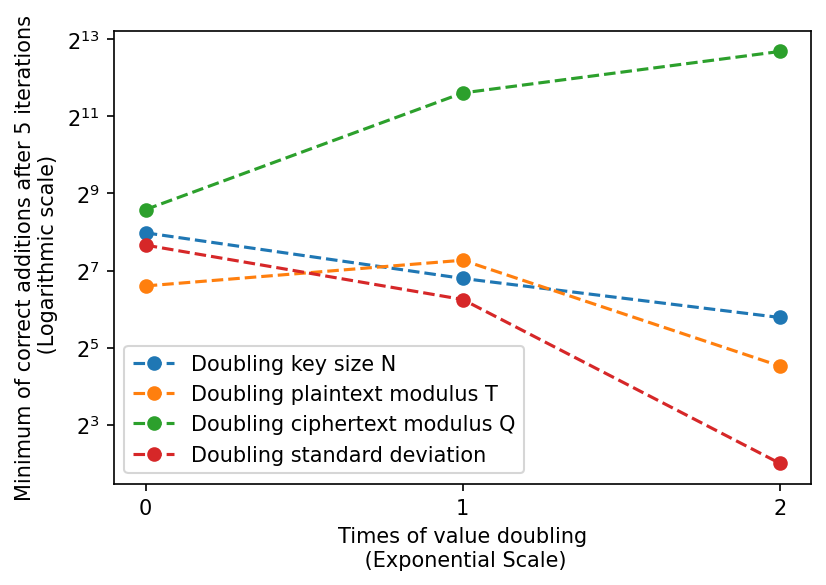

In [18]:
plt.figure(dpi=150)
plt.plot(doubling_N, '--o', label = 'Doubling key size N')
plt.plot(doubling_T, '--o', label = 'Doubling plaintext modulus T')
plt.plot(doubling_Q, '--o', label = 'Doubling ciphertext modulus Q')
plt.plot(doubling_STD, '--o', label = 'Doubling standard deviation')
plt.legend()
plt.yscale('log', base = 2); plt.xticks(range(doublings))
plt.ylabel(f"Minimum of correct additions after {runs} iterations\n (Logarithmic scale)")
plt.xlabel("Times of value doubling\n (Exponential Scale)")
plt.show()

To summarize the above, we indeed computationally verify {eq}`number-of-additions` containing the factors $Q, T^{-1}$ and $1/\sqrt{N}$ as they each correspond to a dotted line.
Furthermore, the diagram shows that doubling the standard deviation $\sigma$ is even worse than doubling $T$ in terms of correct additions.

## Multiplying ciphertexts
### Overview

Multiplying RLWE ciphertexts in a clever way is not only a crucial part of designing a homomorphic encryption scheme, but it also can be seen as a whole concept in general, which can be extended to several special cases.
Some of these will later be considered during {ref}`preparations-for-bootstrapping`, which underlines the relevance of multiplication for the entire FHE scheme.
For example, the bootstrapping procedure itself can be broken down to scaling up a message hidden in a RLWE ciphertext by a (large) factor.

The state of the art FHE schemes would be significantly faster and more efficient, if the inherent multiplication algorithms would be in any way comparable to addition procedures. 
Apart from a more advanced description compared with addition, the main thing, which causes multiplication algorithms to be "expensive", is the error resulting from it.
In the presented scheme, it seems inevitable that the error (during multiplication) will get multiplied by a certain factor, in contrast to addition, where we only had added two errors.
Although we will explain some approaches of diminishing the size of this factor and thus the size of the error afterwards in general, scaling up the error size during multiplication procedures still cannot be entirely avoided.

### Motivation

Although we will use multiplication for the more general notion of RLWE ciphertexts later as well, we will first stick to the BFV case.
For simplicity, and according to our implementation with powers of two $T<Q$, we will drop the rounding of $\round{Q/T}$ from now on. 
Taking two BFV ciphertexts of their form $(a_i,-a_i\cdot s + e_i + (Q/T) M_i)$ for messages $M_0,M_1$, we immediately observe that it is mandatory for a BFV multiplication algorithm to multiply the second components $-a_i\cdot s + e_i + (Q/T) M_i$, yielding a term including $M_0M_1$.
Because of the additive structure being not compatible with multiplication in a linear way, we can already presume that we will obtain several summands, which are dispensable and, in the error case, even obstructive for further operations on ciphertexts.

In total, if we denote the BFV ciphertexts as $(a_0,b_0)$ and $(a_1,b_1)$, the multiplication $b_0b_1$ yields the following nine summands, which we will need to somehow regroup into three (a secret key component, an error and one containing the hidden $M_0M_1$) of a regular BFV ciphertext:

```{math}
:label: b-0b-1
\begin{split}
b_0b_1 &= \underbrace{a_0a_1 \mathrm{sk}^2}_{\text{Precomputation of }\mathrm{sk}^2 \text{ is necessary}} \\
&- \underbrace{(a_0e_1+a_1e_0)\mathrm{sk} - (a_0M_1+a_1M_0)( Q/T)\mathrm{sk}}_{\text{Gives rise to first component of the product}} \\
&+ \underbrace{e_0e_1 + ( Q/T) (e_0M_1 +e_1M_0)}_{\text{Inevitable and large error term}} \\
&+ \underbrace{(Q/T)^2 M_0M_1}_{\text{Wrongly scaled message product}}
\end{split}
```
We will now describe these four aspects in detail.

### Relinearization Keys
We start with the problem of eliminating $a_0a_1\mathrm{sk}^2$.
For that we need an outsourced precomputation, that is mainly an encryption of $\mathrm{sk}^2$, which clearly needs to be done by a party with knowledge of $\mathrm{sk}$.
Since encrypting always comes together with an (additive) error (see {prf:ref}`error-after-BFV-encryption`) and we need to multiply the encryption of $\mathrm{sk}^2$ afterwards with $a_0a_1$, we cannot let this error grow too much.
To clarify the latter, recall that multiplying with $a_0a_1$ or any other public ring element, works via multiplying both components of a BFV/RLWE ciphertext by $a_0a_1$, which also multiplies the intrinsic error with $a_0a_1$.

This sparks the idea of encrypting $\mathrm{sk}^2$ via a larger auxiliary modulus $P\cdot Q$ (for a large $P$), in order to scale down the error afterwards by dividing by $P$ again.
Later, we will investigate this key concept further by introducing a general "rescaling" procedure.
Needless to say, we then need to encrypt $P\cdot \mathrm{sk}^2$ instead of $\mathrm{sk}^2$, since the message, $P\cdot \mathrm{sk}^2$, will get divided by $P$, too.

The following algorithm computes the "relinearization keys", named by the principle of making the multiplied ciphertext $b_0b_1$ linear in $\mathrm{sk}$ again.

The relinearization keys are set to:

$$
\mathrm{rlk} := (\mathrm{rlk}_0, \mathrm{rlk}_1) := (\mathrm{rlk}_0, - \mathrm{rlk}_0 \cdot \mathrm{sk} + e_{\text{rlk}} + P\cdot\mathrm{sk}^2 ) \in R_{PQ}^2 
$$

where $\mathrm{rlk}_0 \sim \mathcal U(R_{PQ})$ and $e_{\text{rlk}} \sim \mathcal N_d(0, \sigma^2)$.

In [19]:
def relinearization_key(ciphertext_modulus, auxiliary_modulus, standard_deviation, secret_key):
    Q, P, STD, SK = ciphertext_modulus, auxiliary_modulus, standard_deviation, secret_key
    PQ, N = P*Q, getattr(SK, 'ring_degree')
    rlk_0 = generate_uniform_distribution(N, 0, PQ-1)
    e_rlk = generate_gaussian_distribution(N, 0, STD)
    rlk_1 = SK.multiply(SK).scalar_multiply(P).subtract(rlk_0.multiply(SK).add(e_rlk), PQ)
    return [rlk_0, rlk_1]

It is important to note, that the parameter $\sigma$ for the error distribution of $e_{\text{rlk}}$ should greatly differ from the analogous parameter used during (regular) encryption.
In {cite}`BFV`, Section 6.1, a precise analysis of this subject is given.
Again, because security issues are not the main concern of our implementations and large variances are obstructive for performances of homomorphic operations, we will overlook this fact by continuing to use $\sigma = 1$ in both cases.

The following lemma (see Section 4 of {cite}`BFV`) assesses the error after completing the relinerazation process, i.e. the error belonging to an encryption of $a_0a_1\mathrm{sk}^2$.

````{prf:lemma} Relinearization error
:label: relinearization-error

Assuming $\norm{e_{\text{rlk}}} \le D$, the error $e_{\text{rel}}$ inside an encryption of $a_0a_1\mathrm{sk}^2$ satisfies:
```{math}
\norm{e_{\text{rel}}} \le \frac{Q\cdot D \cdot N}{P} + \frac{N+1}{2}.
```
````

````{prf:proof}
Set
```{math}
(r_0,r_1) := \left( \round{\frac{a_0a_1 \mathrm{rlk}_0}{P}}, \round{\frac{a_0a_1 \mathrm{rlk}_1}{P}} \right) \in R_Q^2.
```
Then $\norm{e_{\text{rel}}} = \norm{r_0 \mathrm{sk} + r_1 - a_0a_1\mathrm{sk}^2}$.
It follows that
```{math}
\norm{e_{\text{rel}}} = \norm{r_0 \mathrm{sk} + \round{\frac{a_0a_1(e_{\text{rlk}} - \mathrm{rlk}_0 \mathrm{sk})}{P}}}.
```
Now, we have $\norm{\round{a_0a_1e_{\text{rlk}}/P}} \le QDN/P$, because $a_0a_1 \in R_Q$ and $N$ is the worst-case expansion factor resulting from multiplying in $R$.
We are left to estimate a term in the shape of $\round c \mathrm{sk} - \round{c \cdot \mathrm{sk}} + 1/2$, with $c = a_0a_1\mathrm{rlk}_0/P \in \Q[x]/\langle x^N + 1\rangle$.
Because $\norm{\mathrm{sk}} = 1$, the "different rounding" for each coefficient is off by at most $1/2$, thus in total the infinity norm is bounded by $N/2 + 1/2$.
The claim follows.
````

In the above lemma, $P$ should be selected such that $QDN/P < 1$, i.e. keeping $e_{\text{rel}}$ as small as possible while taking into account that the computational complexity increases with a larger $P$.
As shown in the proof, the summand $(N+1)/2$ is an estimator for a very unlikely worst case.
Equilibrating effects of summing rounded integers and $\mathrm{sk} \sim \mathrm{Ter}_{1/3}$ lead to a way smaller error in the average case.

### Core of multiplying

After subtracting $a_0a_1\mathrm{sk}^2$ from $b_0b_1$ in {eq}`b-0b-1`, we proceed with eliminating the dispensable single $Q/T$ inside $(Q/T)^2 M_0M_1$.
Hence we need to scale the latter via integer-dividing (i.e. dividing and rounding) by $T/Q$, which can naturally only be done implicitly by operating on $b_0b_1$.
We will employ this technique as well for other terms consisting of $a_i$ and $b_i$, see below.

Apart from the inevitable error term of multiplying in {eq}`b-0b-1`, we are now left with setting up the first component of the product ciphertext, which consists of a $R_Q$-element, which gets multiplied by $\mathrm{sk}$ during decryption.
Hence this $R_Q$-element should correspond to the term linear in $\mathrm{sk}$ in {eq}`b-0b-1`.
For defining the first component we consider the cross-combination of $a_i$ and $b_i$:

$$
a_0b_1 + a_1b_0 = -2a_1a_0\mathrm{sk} + (a_0e_1+a_1e_0) + (a_0M_1+a_1M_0) (Q/T)
$$

Notice that multiplying the left hand side by $\mathrm{sk}$ (occurs during decryption) yields similar, yet not entirely indentical summands compared to the second line in {eq}`b-0b-1` (bar the scaling by $T/Q$).

All questions raised from {eq}`b-0b-1` now being answered in theory, we will introduce the common notation of $\Delta := Q/T$ before describing the actual algorithm:
As a first step, we want to merge the following three ciphertexts into two:

$$
c_0 := \lfloor \Delta^{-1} a_0a_1 \rceil, \qquad c_1 := \lfloor \Delta^{-1} (a_0b_1+a_1b_0) \rceil, \qquad c_2 := \lfloor \Delta^{-1} b_0b_1 \rceil
$$

Using the relinearization keys $\mathrm{rlk}$, we define the ciphertext of the product as:

$$
c_{\text{mult}} := (c_{\text{mult},0},c_{\text{mult},1}) :=  (c_1 + \lfloor(c_0 \cdot \mathrm{rlk}_0) / P\rceil , c_2 + \lfloor (c_0 \cdot \mathrm{rlk}_1) / P \rceil)
$$

If we apply the main query of decryption, i.e. computing $c_{\text{mult},0}\cdot \mathrm{sk} + c_{\text{mult},1}$, we obtain the following:

```{math}
\begin{split}
c_{\text{mult},0} \cdot \mathrm{sk} + c_{\text{mult},1} &= \lfloor \Delta^{-1} (a_0b_1+a_1b_0) \rceil \mathrm{sk} + \lfloor(c_0 \cdot \mathrm{rlk}_0) / P\rceil \mathrm{sk} + c_2 + \lfloor (c_0 \cdot \mathrm{rlk}_1) / P \rceil\\
    &= \lfloor \Delta^{-1} (a_0(-a_1\cdot \mathrm{sk} + e_1 + \Delta M_1)+a_1(-a_0\cdot \mathrm{sk} + e_0 + \Delta M_0)) \rceil \mathrm{sk} \\
    &+ \lfloor(\lfloor \Delta^{-1} a_0a_1 \rceil \cdot \mathrm{rlk}_0) / P\rceil \mathrm{sk} + \lfloor \Delta^{-1}  (a_0a_1 \mathrm{sk}^2 - (a_0e_1+a_1e_0)\mathrm{sk} - (a_0M_1+a_1M_0)\Delta)\mathrm{sk} \\
    &+ e_0e_1 + \Delta (e_0M_1 +e_1M_0) + \Delta^2 M_0M_1) \rceil + \lfloor (\lfloor \Delta^{-1} a_0a_1 \rceil \cdot (- \mathrm{rlk}_0 \cdot \mathrm{sk} + e_{\text{rlk}} + P\cdot\mathrm{sk}^2 )) / P \rceil \\
    &\approx \lfloor \Delta^{-1} e_0e_1 \rceil + (e_0M_1+e_1M_0) + e_{\text{rel}} + \Delta M_0 M_1
\end{split}
```

Remark on the calculation:
For readability reasons all details on the modular arithmetic (e.g. difference of working in $R$ or $R_Q$ respectively $R_{PQ}$) have been omitted in the above.
Their presence becomes clearer in the code and their effect on the error analysis is described below.

In the last approximation step, all the rounding errors have been temporarily ignored to highlight the main components.
We observe three error summands plus the scaled product of $M_0M_1$ - the result it precisely satisfying the structure of a BFV ciphertext.
Whereas the size of $\Delta^{-1}e_0e_1$ and $e_{\text{rel}}$ (see {prf:ref}`relinearization-error`) seem decent, the size of the second error term $e_0M_1+e_1M_0$ remains the main concern, since it relies on $M_i$ (thus on $T$) and is of multiplicative kind, too.
We will investigate the total error after a multiplication further, after stating the code.

In [20]:
def multiply(ciphertext1, ciphertext2, plaintext_modulus, ciphertext_modulus, auxiliary_modulus, relinearization_keys):
    ct1, ct2, Q, T, P, rlk = ciphertext1, ciphertext2, ciphertext_modulus, plaintext_modulus, auxiliary_modulus, relinearization_keys    
    c_0 = ct1[0].multiply(ct2[0]).rounded_integer_divide(Q//T, Q)
    c_1 = ct1[0].multiply(ct2[1]).add(ct1[1].multiply(ct2[0])).rounded_integer_divide(Q//T, Q)
    c_2 = ct1[1].multiply(ct2[1]).rounded_integer_divide(Q//T, Q)
    c_00 = c_0.multiply(rlk[0]).rounded_integer_divide(P).mod(Q)
    c_01 = c_0.multiply(rlk[1]).rounded_integer_divide(P).mod(Q)
    return [c_1.add(c_00, Q), c_2.add(c_01, Q)]

As an example, we compute $1 \cdot 1$ in ciphertext space:

In [21]:
N, T, Q = 2**2, 2**2, 2**20 
rlk = relinearization_key(Q, Q**2, STD, SK) # P = Q^2 yields relinearization modulus Q^3
Product_Encryption = multiply(One_Encryption, One_Encryption, T, Q, Q**2, rlk)
Product_Decryption = print_and_return("Product of 1*1", decrypt(Product_Encryption, T, Q, SK))
print("Multiplied 1*1 correctly?", Product_Decryption.is_equal_to(generate_constant_poly(N,1)))

Product of 1*1 = 1
Multiplied 1*1 correctly? True


### Error analysis

To derive a worst-case bound for the error after one multiplication, we will follow the approach in {cite}`BFV`, Section 4.

Firstly, we will introduce an useful notation for $\mathrm{ct}_i := (a_i,b_i)$, that is interpreting $\mathrm{ct}_i$ as a polynomial as $\mathrm{ct}_i(x) := a_i x + b_i$.
Using that, we have (in $R$):
```{math}
:label: multiplication-approximation
\Delta^{-1}\cdot (\mathrm{ct}_0 \cdot \mathrm{ct}_1)(\mathrm{sk}) = c_0\mathrm{sk}^2 + c_1\mathrm{sk} + c_2 + e_{\text{approx}}.
```
The goal is to estimate the left hand side.
The right hand side is the approximation, whose $c_i$ are part of the algorithm, and it still contains the relinearization term, which was previously analysed.

Notice that $e_{\text{approx}} \in \Q[x]/\langle x^N+1\rangle$ in the equation and its norm can be estimated as $\approx \delta_R^2$.
The multiplication expansion factor $\delta_R := \max \{\norm{ab}/(\norm a\norm b): a,b \in R\}$ will be further useful (see {ref}`conclusion-on-delta_R`).
Its value is at most $\delta_R' = N$ and for special cases, i.e. using $a, b$ sampled from e.g. $\mathrm{Ter}_{1/3}, \mathcal N_d(0,\sigma^2), \mathcal U (R_Q)$, usually around $\delta_R = \sqrt{N}$.
To verify the estimation, consider e.g. for $c_0$:
```{math}
\norm{\Delta^{-1}(a_0a_1\mathrm{sk}^2) - c_0\mathrm{sk}^2} = \norm{(\Delta^{-1}a_0a_1 - \round{\Delta^{-1}a_0a_1})\mathrm{sk}^2}\le (1/2) \delta_R \delta_R,
```
using $\norm{\mathrm{sk}^2} \le \delta_R$ for $\mathrm{sk} \sim \mathrm{Ter}_{1/3}$.
Now, the same bound holds for the terms of $c_1$ and $c_2$, yielding (approximately) $\norm{e_{\text{approx}}} \le \delta_R^2 = N$.

We will now write $\mathrm{ct}_i(\mathrm{sk}) \in R$ as $e_i + \Delta \cdot M_i + Q \cdot f_i$ with $\norm{f_i} \le \delta_R$ as well. 

Before starting to estimate the size of the left hand side in {eq}`multiplication-approximation`, we need two estimations regarding modular reduction (denoted by e.g. $[x]_T$ to clarify $x \in R_T$).

```{math}
M_0M_1 = [M_0M_1]_T + T \cdot f_M, \qquad e_0e_1 = [e_0e_1]_\Delta + \Delta \cdot f_e.
```

Because $\norm{M_i} \le T/2$, we have $\norm{f_M} \le NT/4$, where $\delta_R'$ must be used, since messages are not drawn samples from distributions.
Similarly, if $\norm{e_i} \le E$, then $\norm{f_e} \le \delta_R E^2\Delta^{-1}$.
Now as a calculation shows, the left hand side in {eq}`multiplication-approximation` equals:
```{math}
:label: estimation-of-multiplication
\begin{split}
&\Delta[M_0M_1]_T + (M_0e_1+M_1e_0) + T(e_0f_1+e_1f_0) + f_e + \Delta^{-1}[e_0e_1]_\Delta \\
&+ Q(M_0f_1+M_1f_0+f_M) + QTf_0f_1.
\end{split}
```
Notice that the second line ultimately vanishes modulo $Q$ and in the first line only $\Delta^{-1}[e_0e_1]_\Delta$ (with norm $\le 1$) has rational coefficients.

We may now summarize the error analyis in a theorem, which is similar to Lemma 2 in {cite}`BFV`.

````{prf:theorem} Error after BFV multiplication
:label: error-after-BFV-multiplication
The error size after multiplying two BFV ciphertexts $(a_i,-a_i\cdot \mathrm{sk} + e_i + \Delta\cdot M_i)$ with $\norm{e_i} \le E$ and $\norm{\mathrm{sk}} = 1$ can approximately be bounded by $2\cdot T\cdot E\cdot N$.
````

````{prf:proof}
If we substitute {eq}`estimation-of-multiplication` in {eq}`multiplication-approximation`, reducing modulo $Q$ and rounding yields:
```{math}
\Delta [M_0M_1]_T + (M_0e_1+M_1e_0) + T(e_0f_1+e_1f_0) + f_e + \round{\Delta^{-1}[e_0e_1]_\Delta - e_{\text{approx}}}
= [c_0\mathrm{sk}^2 + c_1\mathrm{sk} + c_2]_Q
```
The norms of the summands estimate as follows:
```{math}
\begin{split}
\norm{M_0e_1+M_1e_0} &\le 2 (T/2) E \delta_R = TE\sqrt{N} \\
\norm{T(e_0f_1+e_1f_0)} &\le T \cdot 2 E \delta_R^2 = 2TEN \\
\norm{f_e + \round{\Delta^{-1}[e_0e_1]_\Delta - e_{\text{approx}}}} &\le \delta_R E^2 \Delta^{-1} + (1 + N) \le \sqrt{N}E + N
\end{split}
```
since $E < \Delta$ (for correct decryption).
Clearly, $2TEN$ is the dominant term.
Together with $e_{\text{rel}}$ (negligible size, see {prf:ref}`relinearization-error`), whose relinearzation procedure eliminates $c_0\mathrm{sk}^2$ in the above, the claim follows.
````

Continuing the above example of multiplying $1\cdot 1$ in encrypted form, we want to test computationally if the bound $2\cdot TEN$, or more generally $C\cdot TEN$ with a constant $C > 2$, holds with high probability.

In [22]:
N, T, Q, iterations, counter, Max_C = 2**2, 2**2, 2**20, 10000*speed, 0, 2
Delta_One = generate_one_poly(N).scalar_multiply(Q//T)
for i in range(iterations):
    One_Enc = encrypt(generate_one_poly(N), T, Q, 1, PK)
    Product = multiply(One_Enc, One_Enc, T, Q, Q**2, rlk)
    E = One_Enc[0].multiply(SK).add(One_Enc[1]).subtract(Delta_One).mod_small(Q).norm()
    Product_Norm = Product[0].multiply(SK).add(Product[1]).subtract(Delta_One).mod_small(Q).norm()
    if Product_Norm <= 2*(E+1)*N*T:
        counter += 1
    else:
        Max_C = max(Max_C, Product_Norm/(E*N*T))
print(f"Out of {iterations} iterations: ratio of correct bound {counter/iterations}")
print(f"Maximum C was {Max_C}")

Out of 10000 iterations: ratio of correct bound 1.0
Maximum C was 2


(preparations-for-bootstrapping)=
# Preparations for bootstrapping
## RLWE ciphertexts
### Motivation

Bootstrapping, apart from some minor precomputations, happens entirely in ciphertext spaces like $R_Q$.
Hence, as the presented bootstrapping procedure from {cite}`boot` is technically applicable to any RLWE-based scheme (CKKS, BFV, BGV, etc.), it is helpful to simplify the notion of a ciphertext, such that it becomes independent of various encoding techniques, e.g. BFV.

We universally speak of a RLWE-ciphertext, similiar to {prf:ref}`RLWE-distribution`, of a message $m$ encrypted under the secret key $s$ using the ciphertext modulus $Q$ and denote it as:

$$
\mathrm{RLWE}_{Q,s}(m) := (a, -a\cdot s+e+m) \in R_Q^2.
$$

We occasionally omit the indices, if $Q$ respectively $s$ are clear from the context.
If the corresponding error $e$ is $0$, we will write $\mathrm{RLWE}_{Q,s}^0(m)$ instead.
In the same fashion as in BFV encryption, $m$ could be RLWE-encrypted by using a public key only.
Nevertheless, it is not necessary to consider this extention, since we will only work in ciphertext space during bootstrapping.

In [23]:
def rlwe_encryption(message, ciphertext_modulus, standard_deviation, secret_key):
    Q, s, N = ciphertext_modulus, secret_key, getattr(message, 'ring_degree')
    a = generate_uniform_distribution(N, 0, Q-1)
    e = generate_gaussian_distribution(N, 0, standard_deviation)
    b = a.scalar_multiply(-1).multiply(s, Q).add(e).add(message, Q)
    return [a,b]

The goal of bootstrapping now comes down to replacing a large error within $\mathrm{RLWE}_{Q,s}(m)$ with a small fresh one.
By the latter we mean an error with the same size and quality as an error coming from an initial encryption to preserve the security.
Interestingly, bootstrapping can be deconstructed into the core procedure $\texttt{scaled-mod}$ and the surrounding adaption to the BFV scheme.
Informally speaking, $\texttt{scaled-mod}$ only consists of the operation of scaling a $\mathrm{RLWE}(m)$ to $\mathrm{RLWE}(\Delta \cdot m)$ for a large $\Delta$ (different delta from BFV-multiplication).
Since just computing $\mathrm{RLWE}(m) \cdot \Delta$ would also scale the intrinsic error $e$ by $\Delta$, which itself would imply an impossible decryption, the development of techniques to limit error growth during multiplication with ciphertexts is unavoidable.
In this chapter, which is based on {cite}`boot`, Section 2, we will explain some of these techniques and analyse the resulting effect on the error growth.

### Operations on RLWE ciphertexts

To start, we have to define two auxiliary functions, which allow us to effectively deal with RLWE ciphertexts.
The most basic operation is again addition.
It can be done in the same direct way as we have realized BFV addition, namely by adding the components.
In the same fashion this evokes nearly no issues concerning the error, which is only the sum of the previous errors and thus still comparably small.

In [24]:
def rlwe_add(rlwe1, rlwe2, modulus):
    return [rlwe1[0].add(rlwe2[0], modulus), rlwe1[1].add(rlwe2[1], modulus)]

The second operation is multiplication with a polynomial $p$ in both components.
As mentioned earlier, this includes multiplication of the error and message likewise.

In [25]:
def rlwe_multiply_with_poly(rlwe, poly, modulus):
    return [rlwe[0].multiply(poly, modulus), rlwe[1].multiply(poly, modulus)]

Because we will need it later, note that the error $ep$ after multiplying $\mathrm{RLWE}_{Q,s}(m) := (a, -as+e+m)$ with $p$ has size at most:

```{math}
:label: rlwe-multiply-error-growth
\norm{ e\cdot p}\le \norm e \cdot \#\{p_i : p_i \neq 0\} \cdot \norm{p}.
```

Since the result of $\texttt{rlwe-multiply-with-poly}$ is a ciphertext, which relies on correct decryption (see {prf:ref}`correct-BFV-decryption`), $p$ must be chosen carefully. 
Monomials as $p$ achieve the sharpest bound in this context, i.e. then $\norm{ep} = \norm{e}$, because multiplication with $p$ then only shuffles the coefficients of $e$ with possible change in sign.
If we use a sum of monomials as $p$, we still receive an optimal result, since the error growth is exactly the same, as the comparison between $\texttt{rlwe-add}(\mathrm{RLWE}(m\cdot x^j),\mathrm{RLWE}(m\cdot x^k))$ and $\texttt{rlwe-multiply-with-poly}(\mathrm{RLWE}(m),x^j+x^k)$ shows.
For a general polynomial $p$ and if $p_i$ and $e_i$ are i.i.d. with mean zero, we may also use the standard estimation $\norm{ep}
 \le \delta_R \norm e \norm p$ (see {ref}`conclusion-on-delta_R`).

Following these observations, we will later outsource a polynomial multiplication to many individual monomial multiplications and in particular, our next objective will be the reduction of $\norm{p}$ to smaller values by base-decomposing polynomials/ciphertexts.

## RLWE' ciphertexts
Essentially, a RLWE' ciphertext is a blow-up of a RLWE ciphertext used to better handle error growth during $\texttt{rlwe-multiply-with-poly}$.
Constructing a RLWE' ciphertext will be done by RLWE-encrypting the corresponding message scalar multiplied by powers of a certain base $B > 1$.

To specify the latter, we are scalar multiplying our message with a so-called gadget vector $g := (1,B,B^2,\dots,B^l)$, where $l \in \mathbb N$ is maximal in terms of $B^l < \log_B(Q)$.
The gadget vector has the property of letting any ring element $r\in R_Q$ uniquely get gadget-decomposed into:

```{math}
r = \sum_{i=0}^l g_i \cdot r_i, \qquad \norm{r_i} \le B/2.
```

Basically, this is just the extension of base $B$ decomposition from numbers to polynomials.
The RLWE' encryption of a message $m$ with respect to base $B$ now is defined as:

```{math}
\mathrm{RLWE'}_{Q,s}(m) := (\mathrm{RLWE}_{Q,s}(B^i \cdot m))_{i \in \{0, \dots, l\}} \in R_Q^{l+1}
```

In [26]:
def rlwe_x_encryption(message, ciphertext_modulus, B, standard_deviation, secret_key):
    m, Q, s, STD = message, ciphertext_modulus, secret_key, standard_deviation
    g = [B ** i for i in range(ceil(log(Q, B))) ]
    return [rlwe_encryption(m.scalar_multiply(g[i]), Q, STD, s) for i in range(len(g))]

Remark on $B$: 
Because our scheme uses a power of two as $Q$, it stands to reason for simplicity to use a power of two as $B$ as well.
As $B$ will be a changeable bootstrapping parameter, it has an non-negligible impact on the running time, too.
As we will analyse in the next section, for a larger $B$ there is a fine trade-off between the larger error it induces during RLWE' operations and the faster running times respectively less memory it requires at the same time.

### Operations on RLWE' ciphertexts
If one once again considers the error problem concerning the $\texttt{rlwe-multiply-with-poly}$ algorithm, we may now solve this issue by using our decomposed information hiding inside a RLWE' ciphertext.
Recall that multiplying with a large polynomial $r$ results in too large an error for correct decryption.
Utilizing the above property that $\norm{r_i} \le B/2$, we can improve the size of the error after a multiplication by splitting up the multiplication process among the $r_i$'s.

We define the so-called scalar multiplication $\odot$ of a RLWE' ciphertext with a polynomial $r \in R_Q$ using the above notation as:

```{math}
\texttt{rlwe-x-scalar-multiply}: r \odot \mathrm{RLWE'}_{Q,s}(m) := \sum_{i=0}^l r_i \cdot \mathrm{RLWE}_{Q,s}(B^i \cdot m)
```

The above uses the homomorphic procedures for RLWE ciphertexts, i.e. $\texttt{rlwe-add}$ and $\texttt{rlwe-multiply-with-poly}$, to compute the right hand side.
Hence we have:

```{math}
\sum_{i=0}^l r_i \cdot \mathrm{RLWE}_{Q,s}(B^i \cdot m) = \mathrm{RLWE}_{Q,s} \left( \sum_{i=0}^l r_i \cdot B^i \cdot m \right) = \mathrm{RLWE}_{Q,s}(r\cdot m)
```

So in total, $\texttt{rlwe-x-scalar-multiply}$ enables us to compute $\texttt{rlwe-multiply-with-poly}(\mathrm{RLWE}(m), r)$ with a smaller error, whose size we will analyse after stating the algorithm.

In [27]:
def rlwe_x_scalar_multiply(r_Q, rlwe_x, ciphertext_modulus, B):
    l = ceil(log(ciphertext_modulus, B))
    r = r_Q.base_decompose(B, l)
    result = [generate_constant_poly(getattr(r_Q, 'ring_degree'), 0) for _ in range(2)]
    for i in range(l):
        temp = rlwe_multiply_with_poly(rlwe_x[i], r[i], ciphertext_modulus)
        result = rlwe_add(result, temp, ciphertext_modulus)
    return result

````{prf:lemma} Error after $\texttt{rlwe-x-scalar-multiply}$
:label: error-after-rlwe-x-scalar-multiply
Scalar multiplying $\mathrm{RLWE'}_{Q,s}(m)$ (with an error $e$) with $r \in R_Q$, yields an error of size at most $(B/2) \cdot \log_B(Q) \cdot \norm{e} \cdot \delta_R^{(')}$.
````
````{prf:proof}
The procedure $\texttt{rlwe-multiply-with-poly}$ computes $er$.
Thus the error size afterwards is $\delta_R^{(')} \cdot \norm{e} \cdot (B/2)$, using an ring expansion factor $\delta_R^{(')}$ dependent on $e$ and $r$ (see {ref}`conclusion-on-delta_R`).
The claim follows, since we then perform $l \approx \log_B(Q)$ additions using $\texttt{rlwe-add}$.
````

Remark: Interestingly, $B \cdot l \approx B \cdot \log_B(Q)$ inside the error bound gets minimal for $B$ equal to Euler's number $\mathrm{e}$, which an easy calculation shows.
If we use a large $B$, on the one hand, the running time/memory usage will be faster/lesser by a factor $\log_B(Q)/\ln(Q) = 1/\ln(B)$ than in the error-wise optimal case with Euler's number.
On the other hand, the error size will then be larger by a factor $B\log_B(Q)/(\mathrm{e}\ln(Q)) = B/(\mathrm{e}\ln(B))$.
Since we will later investigate techniques to scale down an error more efficiently anyway, the trade-off of a larger $B$ and faster computation times etc. is definitely preferable at this point.

## RGSW ciphertexts
The notion of a RGSW (name and idea originate from {cite}`rgsw`) ciphertext adds another layer of complexity.
Namely, it consists of RLWE' encryptions of both $s \cdot m$ and $m$, where $s$ is the secret key.
The scaling with $s$ is necessary, if we extend the idea behind $\texttt{rlwe-x-scalar-multiply}$ to a multiplication with a RLWE ciphertext (and not just a ring element).
This will enable us to define something like $\mathrm{RLWE}(m_1) \circledast \mathrm{RGSW}(m_2) \approx \mathrm{RLWE}(m_1m_2)$, because if $\mathrm{RLWE}(m_1) = (a,b)$, then $as+b = e_1 + m_1$ can be computed without knowledge of $m_1$ by implicitly transferring the multiplication with $s$ to $\mathrm{RGSW}(m_2)$.

We save the details on the $\texttt{star-multiplication}$ $\circledast$ for later and define:

```{math}
\mathrm{RGSW}_{Q,s}(m) := (\mathrm{RLWE'}_{Q,s}(s\cdot m), \mathrm{RLWE'}_{Q,s}(m)) \in R_Q^{2(l+1)}.
```

Note that given $\RLWEx(m)$, one does not explicitly need $s$ for obtaining $\RLWEx(s \cdot m)$, because it holds that:
```{math}
\RLWE(s \cdot B^i \cdot m) = \RLWE(0) + (B^i \cdot m, 0).
```

In [28]:
def rgsw_encryption(message, ciphertext_modulus, B, standard_deviation, secret_key):
    m, Q, s, STD = message, ciphertext_modulus, secret_key, standard_deviation
    return [rlwe_x_encryption(m.multiply(s, Q), Q, B, STD, s), rlwe_x_encryption(m, Q, B, STD, s)]

### Operations on RGSW ciphertexts

Again, we start with the straightforward component-wise addition $\texttt{rgsw-add}$ to obtain $\RGSW(m_1+m_2)$ from $\RGSW(m_1)$ and $\RGSW(m_2)$.
Since a $\RGSW$ ciphertext builds on $\RLWEx$ ciphertexts, which themself build on $\RLWE$ ciphertext, we apply $\texttt{rlwe-add}$ in the bottom level to obtain the desired result.
The error analyis is identical to the one in $\texttt{rlwe-add}$.

In [29]:
def rgsw_add(rgsw1, rgsw2, ciphertext_modulus = None):
    l = len(rgsw1[0])
    result = [[[0,0] for _ in range(l)] , [[0,0] for _ in range(l)]]
    for i in range(2):
        for j in range(l):
            result[i][j] = rlwe_add(rgsw1[i][j], rgsw2[i][j], ciphertext_modulus)             
    return result

In the above fashion of RLWE ciphertexts, we can extend the component-wise multiplication with a specific polynomial $r \in R_Q$ to RGSW ciphertexts.
Needless to say, the same error discussion as in $\texttt{rlwe-multiply-with-poly}$ applies:
It is mandatory that we only multiply with a $r$ of small size, otherwise we will decrypt the result wrongly (below indicated by $\leadsto$).

More formally we have:

```{math}
\begin{split}
\texttt{rgsw-multiply-with-poly}: \mathrm{RGSW}_{Q,s} \times R_Q &\longrightarrow \mathrm{RGSW}_{Q,s}, \\
(\mathrm{RGSW}_{Q,s}(m), r) &\leadsto \mathrm{RGSW}_{Q,s}(r\cdot m)
\end{split}
```

In [30]:
def rgsw_multiply_with_poly(rgsw, poly, ciphertext_modulus):
    l = len(rgsw[0])
    result = [[[0,0] for _ in range(l)] , [[0,0] for _ in range(l)]]
    for i in range(2):
        for j in range(l):
                result[i][j] = rlwe_multiply_with_poly(rgsw[i][j], poly, ciphertext_modulus)
    return result

### The star multiplication
The star multiplication $\circledast$ can be seen as the most central auxiliary operation of the bootstrapping scheme.
It effectively minimizes the error growth when multiplying a particular kind of ciphertext (a RGSW-encrypted monomial) by exploiting the structure of RLWE' ciphertexts.
Unlike BFV multiplication (see {prf:ref}`error-after-BFV-multiplication`), the error after $\circledast$ directly depends on the size of a message belonging to (only) one factor.

As a description of $\circledast$ we have:

```{math}
\begin{split}
\texttt{star-multiplication} = \circledast: \mathrm{RLWE}_{Q,s} \times \mathrm{RGSW}_{Q,s} &\longrightarrow \mathrm{RLWE}_{Q,s}, \\ (\mathrm{RLWE}_{Q,s}(m_1), \mathrm{RGSW}_{Q,s}(m_2)) &\leadsto \mathrm{RLWE}_{Q,s}(m_1\cdot m_2+e_1m_2)
\end{split}
```

The above shows what the result is rather than how it is actually defined.
Unfolding the components gives rise to the definition:

```{math}
\begin{split}
\underbrace{\mathrm{RLWE}_{Q,s}(m_1)}_{=: (a,b)} \circledast \mathrm{RGSW}_{Q,s}(m_2) &:= a \odot \mathrm{RLWE'}_{Q,s}(s\cdot m_2) + b \odot \mathrm{RLWE'}_{Q,s}(m_2) \\
&= \mathrm{RLWE}_{Q,s}((a\cdot s +b)m_2) \\
&= \mathrm{RLWE}_{Q,s}(m_1\cdot m_2+e_1m_2).
\end{split}
```

Here we have implicitly applied the auxiliary functions $\odot$ and $\texttt{rlwe-add}$ from above and we have used that $a \cdot s + b = m_1 + e_1$.
Finally, it becomes clear, why we originally needed the concept of RGSW ciphertexts (i.e. the additional multiplication with $s$).

In [31]:
def star_multiplication(rlwe, rgsw, ciphertext_modulus, B): 
    summand1 = rlwe_x_scalar_multiply(rlwe[0], rgsw[0], ciphertext_modulus, B)
    summand2 = rlwe_x_scalar_multiply(rlwe[1], rgsw[1], ciphertext_modulus, B)
    return rlwe_add(summand1, summand2, ciphertext_modulus)

The error analysis is simple:

````{prf:lemma} Error after $\texttt{star-multiplication}$
:label: error-after-star-multiplication
The error size after $\RLWE_{Q,s}(m_1) \circledast \RGSW_{Q,s}(m_2)$ is approximately bounded by $B \cdot \log_B(Q) \cdot \norm {e_2} \cdot \sqrt{N} + \norm{e_1m_2}$.
````
````{prf:proof}
The result after $\circledast$ is an encryption of $m_1m_2$ altered by $e_1m_2$, thus $\norm{e_1m_2}$ is the estimation.
Now, following {prf:ref}`error-after-rlwe-x-scalar-multiply`, both components from $\RLWE(m_1)$ can be treated as $\mathcal U(R_Q)$ samples due to {prf:ref}`decision-RLWE`.
Together with the assumption that $e_2$ (i.e. its coefficients) is distributed with mean zero (see {ref}`conclusion-on-delta_R`), we can select $\delta_R = \sqrt{N}$ in {prf:ref}`error-after-rlwe-x-scalar-multiply`.
Since we add two RLWE ciphertexts at the end, the claim follows.
````

Notice that $\norm{e_1m_2} \le N \norm{e_1}\norm{m_2}$ in the worst case, since $m_2$ could be arbitrary.
However, we will only use monomials as $m_2$ in our algorithm, such that $\norm{e_1m_2} = \norm{e_1}$ holds.

### The extended star multiplication
We can extend the star multiplication from RLWE to RLWE' ciphertexts by again applying it component-wise.
Using the same notation out of comfort, the map is:

```{math}
\begin{split}
\texttt{star-x-multiplication} = \circledast: \mathrm{RLWE'}_{Q,s} \times \mathrm{RGSW}_{Q,s} &\longrightarrow \mathrm{RLWE'}_{Q,s}, \\ (\mathrm{RLWE'}_{Q,s}(m_1), \mathrm{RGSW}_{Q,s}(m_2)) &\leadsto \mathrm{RLWE'}_{Q,s}(m_1\cdot m_2+e_1m_2)
\end{split}
```

In [32]:
def star_x_multiplication(rlwe_x, rgsw, modulus, B):
    return [star_multiplication(rlwe_x[i], rgsw, modulus, B) for i in range(len(rlwe_x))]

Technically, the $\texttt{star-x-multiplication}$ can now be extended even to a multiplication of two RGSW ciphertexts, as suggested in Section 2 of {cite}`bootstrapping-in-fhew`.
Although we will not use it, if one needs a RGSW encryption of the result of $\circledast$, the $\diamondsuit$ operation may be useful:
```{math}
\diamondsuit: \RGSW \times \RGSW \longrightarrow \RGSW, \qquad ((c_1,c_2),C) \longmapsto (c_1 \circledast C, c_2 \circledast C).
```

(automorphisms-of-R)=
## Automorphisms of $R$

Before getting to bootstrapping, we need two more auxiliary operations.
The first one is an automorphism evaluation on elements of $R$ and thus on RLWE ciphertexts, too.
It is a well-known fact that there are exactly $N$ automorphisms of $R$, namely $\psi_i$ for each coprime $i \perp 2N$ (recall that $N$ is a power to two), and they can be denoted by:

```{math}
\psi_i : R \longrightarrow R,  \qquad a(x) \longmapsto a(x^i), \qquad i \in \{1,3,5,\dots,2N-1\}.
```

If we apply $\psi_i$ to a RLWE ciphertext $(a(x), b(x))$, we obtain the ciphertext $(a(x^i), b(x^i))$, which, though it technically encrypts $m(x^i)$, it unfortunately uses $s(x^i)$ as a secret key.
We will get rid of this complication by introducing the $\texttt{key-switch}$ procedure.
Further notice that the application of $\psi_i$ to a ciphertext preserves the error size, since $\norm{e(x^i)} = \norm{e(x)}$.

### Key switching

The objective of this section is to enable the bootstrapping party to execute all $N$ automorphisms (without knowledge of $s$).
To begin with, we mention that for this step we will need the $s(x^i)$ as precomputed information.
Obviously, we need to encrypt $s(x^i)$, thus the following function comes in handy.
It is run by a secret-key holder, sent to the bootstrapping party in advance of bootstrapping and involves RLWE' encryptions (to control the error growth for $\texttt{key-switch}$ later):

```{math}
\texttt{key-switch-for-eval-auto}: (\mathrm{RLWE'}_{Q,s}(s(x^i)))_{i\in \{1,3,\dots,2N-1\}}.
```

In [33]:
def key_switch_for_eval_auto(secret_key, ciphertext_modulus, B, standard_deviation):
    s, Q, STD, N = secret_key, ciphertext_modulus, standard_deviation, getattr(secret_key, 'ring_degree')
    return [[i, rlwe_x_encryption(s.variable_powering(i), Q, B, STD, s)] for i in range(1, 2*N, 2)]

Now, the procedure $\texttt{key-switch}$ below will actually perform the key switching from a secret key $s_1$ to another secret key $s_2$.
So, starting from a ciphertext $\mathrm{RLWE}_{Q,s_1}(m) =: (a,b)$, it outputs $\mathrm{RLWE}_{Q,s_2}(m)$ plus a key-switching error $e_{\text{key-switch}}$.
The defining calculation:

```{math}
\begin{split}
\texttt{key-switch}: \mathrm{RLWE}_{s_2}(m) &:= a \odot \mathrm{RLWE'}_{s_2}(s_1) + (0,b) \\
&= \mathrm{RLWE}_{s_2}(a\cdot s_1) + \mathrm{RLWE}_{s_2}^0(b) \\
&= \mathrm{RLWE}_{s_2}(a\cdot s_1 + b) 
\\ &= \mathrm{RLWE}_{s_2}(m+e_{\text{key-switch}})
\end{split}
```

In [34]:
def key_switch(rlwe, ciphertext_modulus, B, key_switch_rlwe_x):
    a, b, Q, ks = rlwe[0], rlwe[1], ciphertext_modulus, key_switch_rlwe_x
    zero = generate_zero_poly(getattr(b, 'ring_degree'))
    return rlwe_add(rlwe_x_scalar_multiply(a, ks, Q, B), [zero, b], Q)

By construction, $\texttt{key-switch}$ yields the exact same error as in $\texttt{rlwe-x-scalar-multiply}$ (see {prf:ref}`error-after-rlwe-x-scalar-multiply`).
That means an error of size at most $(B/2) \cdot \log_B(Q) \cdot \norm e \cdot \sqrt{N}$, since $\delta_R' = \sqrt{N}$ in the lemma, because $a$ is uniformly at random (see {ref}`conclusion-on-delta_R`).
Note that here $e$ stands for a RLWE encryption error, independent of the error inside $\RLWE_{s_2}(m)$.

### Evaluating automorphism

We are now able to evaluate $\psi_t$ for an arbitrary $t\perp 2N$ on a RLWE ciphertext, since we can change the secret key from $s(x^i)$ to $s$ again after applying $\psi_t$.
The function below transforms $\mathrm{RLWE}_{Q,s}(m(x))$ into $\mathrm{RLWE}_{Q,s}(m(x^t))$ by using $\texttt{key-switch}$ after $t$-powering the polynomial variable $x$.

Remark on the code:
We highlight the precomputational part by storing $t$ right along with the RLWE' encryption of $s(x^t)$ (instead of accessing it directly), since this information will get transmitted by the holder of $s$.

In [35]:
def eval_auto(rlwe, t, ciphertext_modulus, B, key_switch_array):
    a, b, N, Q = rlwe[0], rlwe[1], getattr(rlwe[0], 'ring_degree'), ciphertext_modulus
    eval_a, eval_b = a.variable_powering(t).mod(Q), b.variable_powering(t).mod(Q)
    for i in range(len(key_switch_array)):
        if key_switch_array[i][0] == (t % (2*N)):
            return key_switch([eval_a, eval_b], Q, B, key_switch_array[i][1])

Clearly, the error during an automorphism evaluation is precisely equal to the error of $\texttt{key-switch}$.

As a demonstration, we apply the transformation $x \longmapsto x^3$ for a randomly selected message.

In [36]:
B = 8  # example selection
key_switch_array = key_switch_for_eval_auto(SK, Q, B, STD) # precomputation

Random_Poly = print_and_return("Message", generate_uniform_distribution(N, 0, T-1))
Random_Poly_Enc = encrypt(Random_Poly, T, Q, STD, PK)
Morphed = eval_auto(Random_Poly_Enc, 3, Q, B, key_switch_array)
print(f"Message after eval-auto: x --> x^3: {decrypt(Morphed, T, Q, SK)}")
print(f"Note that x^({two_power(N)}) = -1 and coefficients are mod {two_power(T)}.")

KS_error = Morphed[0].multiply(SK).add(Morphed[1]).subtract(Random_Poly.variable_powering(3).scalar_multiply(Q//T), Q)
print(f"Error size after key switching: {KS_error.mod_small(Q).norm()}")
print(f"Factor from error bound: (B/2) * log_B(Q) * sqrt(N) = {(B/2)*log(Q,B) * sqrt(N)}")

Message = 3x^3 + x^2 + 3x + 3
Message after eval-auto: x --> x^3: 3x^3 + 3x^2 + 3x + 3
Note that x^(2^2) = -1 and coefficients are mod 2^2.
Error size after key switching: 34
Factor from error bound: (B/2) * log_B(Q) * sqrt(N) = 53.333333333333336


The code also illustrates the error growth during $\texttt{key-switch}$.
It prints the factor $(B/2) \log_B(Q) \sqrt{N}$ from {prf:ref}`error-after-rlwe-x-scalar-multiply`, which gets multiplied with the intrinsic error size from the original encryption.
We observe that the error after key switching is usually much smaller than the bound times at least 1.

(rescaling)=
## Rescaling

The last key step, which has already been implicitly employed during the multiplication of BFV ciphertexts, is the rescaling procedure.
Recall how we introduced the auxiliary modulus $P$ within the relinearization key (see e.g. {prf:ref}`relinearization-error`).
To sum it up, its main purpose was scaling down a big error to a small one.
The simple way to do that was just to divide both components of a ciphertext by the factor $P$.
Notice that in this case the hidden message gets divided by $P$, too.
We had handled this side effect by having multiplied the message by $P$ beforehand, such that division by $P$ afterwards just yields the message again.

Now, the same idea can be generalized to RLWE ciphertexts, in which we want to solely scale down the ciphertext modulus while a priori not preserving the encrpytion of the same message, but a scaled-down version.
So for powers of two $q < Q$, we define:

```{math}
\texttt{rescale}: \mathrm{RLWE}_{Q,s}(m) := (a,b) \longmapsto \left(\round{ \frac{a}{Q/q}} , \round{ \frac{b}{Q/q} } \right)  =: \mathrm{RLWE}_{q,s}\left(\round {\frac{m}{Q/q} }\right).
```

In [37]:
def rescale(rlwe, old_modulus, new_modulus):
    Q, q = old_modulus, new_modulus
    return [rlwe[0].rounded_integer_divide(q, Q//q), rlwe[1].rounded_integer_divide(q, Q//q)]

Remark:
Needless to say, the rounding introduces a rescaling error $e_{\text{res}}$.
As in the proof of {prf:ref}`relinearization-error`, we can estimate its size via:
```{math}
\norm{e_{\text{res}}} = \norm{ \round{ \frac{a}{Q/q}} \cdot s + \round{ \frac{b}{Q/q} } - \round{(as+b)/(Q/q)} } \le \delta_R/2 + 1/2.
```
Since we use the estimation $\delta_R \approx \sqrt{N}$ anyway, we conclude that $\norm{e_{\text{res}}} \le \sqrt{N}/2$.

Rescaling will later be the last part of the core $\texttt{scaled-mod}$ procedure and, thus, the total error, which has been accumulated beforehand, can be scaled down appropriately by $\texttt{rescale}$. 

(bootstrapping)=
# Bootstrapping
## The $\texttt{scaled-mod}$ procedure

The main task during bootstrapping is scaling up a message inside a RLWE ciphertext by a large factor $\Delta$.
Precisely, we want to transform $\mathrm{RLWE}_{2N,s}^0(u)$, with $u$ satisfying $\norm u < N/2$, into $\mathrm{RLWE}_{Q,s}(\Delta \cdot u)$.
How this procedure ($\texttt{scaled-mod}$) can be used to serve the actual purpose of bootstrapping, i.e. scaling down a big error, will be described afterwards.

The above discussion in {ref}`preparations-for-bootstrapping` of multiplying RLWE ciphertexts and especially {prf:ref}`error-after-rlwe-x-scalar-multiply` points out that this is a non-trivial task when using a large $\Delta$, because of error issues.
Once this has been achieved, the rest of our bootstrapping procedure consists of fitting the BFV encryption scheme towards the $\texttt{scaled-mod}$ procedure, i.e. how to obtain the ciphertext of $u$ from a BFV ciphertext and vice versa afterwards.
The name "scaled modulus raising" comes from scaling up by $\Delta$ and from using a significantly larger modulus $Q$ during the process to handle error growth.
At this point we leave questions, e.g. why we initially assume an errorless encryption etc., for later.

$\texttt{scaled-mod}$ itself, which Section 3 of {cite}`boot` covers, includes three steps:

1. The extraction of LWE ciphertexts, where we essentially split up the problem in $N$ single dimensional (LWE) versions.
2. Blind rotation, where the main transformation towards $\Delta \cdot u$ is realized.
It is by far the most costly operation.
3. Repacking, where we reunite our split-up ciphertexts into a single one, which contains all information.

(extraction-of-LWE-ciphertexts)=
## Step 1: Extraction of LWE ciphertexts
In defining LWE ciphertexts, losing the letter 'R' ≙ ring leaves us with integers as messages (whereas in RLWE we have $N$ integers encoded in a polynomial message).
Apart from that, it has a very similar representation:

```{math}
\mathrm{LWE}_{Q,\vec s}(m) := (\vec a, -\langle \vec a, \vec s\rangle + e + m) \in \mathbb Z_Q^{N+1},
```

where $\vec a, \vec s \in \Z_Q^N$ and $e, m \in \Z_Q$.
Again, if $e = 0$, then we will write $\mathrm{LWE}^0$.

Naturally, the LWE ciphertext security has been thoroughly analysed, as the concept was already existent prior to RLWE.
An extensive survey on this topic can be found in Section 4.2 of {cite}`a-decade-of-lattice-cryptography`.
Moreover, since RLWE is based on LWE, if we generate LWE ciphertexts from RLWE ciphertexts, all the security measures (as described in {ref}`security`) apply as well.
To preserve these, we write $\vec s := (s_0,\dots,s_{N-1})$ as the coefficient vector of $s$ and since the RLWE distributions for $a,s$ and $e$ are employed coefficient-wise, their properties still hold up in the context of the related LWE security.

The goal of the extraction essentially is properly representing the calculation of the linear combinations of the coefficients during a polynomial multiplication in $R$:

```{math}
s\cdot a = \left( \sum_{i=0}^{N-1} s_i x^i \right) \left( \sum_{i=0}^{N-1} a_i x^i \right) = \sum_{i=0}^{N-1}\left( \sum_{j=0}^{i} s_j a_{i-j} + \sum_{j=i+1}^{N-1} - s_j a_{i+N-j}\right) x^i =: \sum_{i=0}^{N-1} c_i x^i
```

Notice that the minus sign originates from the choice of $R$, i.e. $x^N=-1$.
Hence, if we want to create a LWE ciphertext per coefficient $c_i$ of the above, we define:

```{math}
\tilde a_i := (a_i,a_{i-1},\dots,a_0,-a_{N-1},-a_{N-2},\dots,-a_{i+1}) \qquad \text{and} \qquad c_i := \langle \tilde a_i, \vec s \rangle = (a \cdot s)_i.
```

In total, we receive $N$ LWE ciphertexts of the form $\mathrm{LWE}_{2N,\vec s}^0(u_i)$, extracted from the given $\mathrm{RLWE}_{2N,s}^0(u) = (a,b)$:

```{math}
\mathrm{LWE}_{2N,\vec s}^0(u_i) := (\tilde{a}_i, b_i) \qquad \text{with} \qquad \langle \tilde a_i, \vec s \rangle + b_i = u_i.
```

In [38]:
def extraction(rlwe):
    a_coeffs, b_coeffs, N = getattr(rlwe[0], 'coeffs'), getattr(rlwe[1], 'coeffs'), getattr(rlwe[0], 'ring_degree')
    a_rotation = [[0 for _ in range(N)] for _ in range(N)]
    for i in range(0, N):
        for j in range(0, i+1):
            a_rotation[i][j] = a_coeffs[i-j]
        for j in range(i+1, N):
            a_rotation[i][j] = -a_coeffs[N + i - j]
    return [[mod(a_rotation[i], 2 * N), mod(b_coeffs[i], 2 * N)] for i in range(N)]

(blind-rotation)=
## Step 2: Blind rotation

Starting from an extracted $\mathrm{LWE}_{2N,\vec s}^0(u) := (\vec \alpha, \beta)$ ciphertext, we want to obtain a RLWE encryption of $\Delta \cdot u$ by using the techniques of {ref}`preparations-for-bootstrapping` to handle the error growth.
Recall that here $u$ is an integer, thus $\Delta \cdot u$ is as well and therefore we have plenty of liberty in choosing the polynomial RLWE message, apart from the desired constant coefficient $\Delta \cdot u$.
On the other hand, we will also need this liberty, because we have no knowledge of what exactly $u$ is, just knowledge of the size estimation $\abs u \le N/2$.

### Rotation function

The above observation leads to the notion of the blind rotation function $f$, which prepares the right scaling with $\Delta$ at all possible coefficients of a RLWE message polynomial.

We define:

```{math}
f := \sum_{j=-c}^c -\Delta\cdot j \cdot x^j \in R, \qquad \text{ where } \abs u \le c < N/2.
```
We will provide the details of $c$ later on.

In [39]:
def initialize_rotation_function(key_size, Delta, c_boundary, ciphertext_modulus):
    function_coeffs = [0 for _ in range(key_size)]
    for j in range(c_boundary + 1):
        function_coeffs[j] = -j*Delta
    for j in range(1, c_boundary + 1):
        function_coeffs[key_size - j] = -j*Delta
    return Poly(key_size, function_coeffs).mod(ciphertext_modulus)

This now allows us, regardless of the special value of $u$, to have that $(f\cdot x^u)(0) = \Delta \cdot u$ (here we have used $\abs u \le c < N/2$ and thus $\mathrm{deg}(f\cdot x^u) < N$) as an easy calculation shows.
Note that at this point the LWE extraction serves its purpose, since $u$ as an integer can be selected as an exponent of $x$ (in contrary to a polynomial message).
Moving $u$ to the exponent, instead of e.g. multiplying it directly with $\Delta$, yields a noteably smaller error.
Recall, that it was already briefly mentioned beforehand (see {eq}`rlwe-multiply-error-growth`) that monomials can be cheaply multiplied with ciphertexts (in terms of error growth) compared to e.g. constants.
We make use of that, but $x^u$ still does not suffice, because it is unknown, hence we have to perform monomial multiplication $N$ times:

```{math}
x^u = x^\beta \cdot x^{\alpha_0 s_0} \cdots x^{\alpha_{N-1} s_{N-1}}, \qquad \text{since } u = \beta + \langle \vec \alpha, \vec s \rangle.
```

Here we utilized the properties of a LWE ciphertext.

Finally, we need to consider:
It is inevitable for a secret key holder to do some precomputation, which on the one hand, encrypts the secret key bits $s_i$ one-by-one, and is, on the other hand, compatible with exponent multiplication, i.e. for later obtaining $x^{\alpha_i s_i}$.
RGSW ciphertexts solve both issues.

### Blind rotation keys

We hide the information about the bits of our ternary secret key $s$ in a stack of $2N$ RGSW ciphertexts.
First of all, a coefficient $s_i \in \{-1,0,1\}$ gets separated into its positive and its negative part.
So we define:

```{math}
s_i^+ = 1 :\iff s_i = 1, \qquad s_i^- = 1 :\iff s_i = -1.
```

Otherwise $s_i^+$ respectively $s_i^-$ is set to $0$.
Now we define the blind rotation keys computed by a secret key holder in advance as:

```{math}
\texttt{blind-rotation-keys}: (\mathrm{RGSW}_{Q,s}(s_i^+), \mathrm{RGSW}_{Q,s}(s_i^-))_{i \in \{0,\dots,N-1\}}.
```

In [40]:
def blind_rotation_keys(ciphertext_modulus, B, standard_deviation, secret_key):
    Q, s, STD, N = ciphertext_modulus, secret_key, standard_deviation, getattr(secret_key, 'ring_degree')
    s_coeffs, zeropoly, onepoly = getattr(s, 'coeffs'), generate_zero_poly(N), generate_one_poly(N)
    brk = [[0,0] for _ in range(N)]
    for i in range(N):
        if s_coeffs[i] == 1:
            brk[i][0] = rgsw_encryption(onepoly, Q, B, STD, s)
        else:
            brk[i][0] = rgsw_encryption(zeropoly, Q, B, STD, s)
        if s_coeffs[i] == -1:
            brk[i][1] = rgsw_encryption(onepoly, Q, B, STD, s)
        else:
            brk[i][1] = rgsw_encryption(zeropoly, Q, B, STD, s)
    return brk

### Blind rotation algorithm

The last missing piece is a trivial (i.e. errorfree and not using the secret key $s$) RGSW encryption of $1$.
We need it such that the following equation holds:

```{math}
\mathrm{RGSW}_{Q,s}(x^{\alpha_i s_i}) = \mathrm{RGSW}_{Q,s}^0(1) + (x^{\alpha_i}-1)\cdot \mathrm{RGSW}_{Q,s}(s_i^+) + (x^{-\alpha_i}-1)\cdot \mathrm{RGSW}_{Q,s}(s_i^-)
```

Recall that either $s_i^+$ or $s_i^-$ is zero.
In this case, the corresponding summand is equal to $\mathrm{RGSW}_{Q,s}(0)$.
Because RGSW errors behave favorably during additions, we merge everything into the result while only performing two $\texttt{rgsw-multiply-with-poly}$ operations with a polynomial $(x^{\pm \alpha_i}-1)$ which is still almost as optimal as a monomial (see below {eq}`rlwe-multiply-error-growth`).

We realize the trivial RGSW encryption of $1$ as follows:

```{math}
\RGSW_{Q,s}^0(1) = (\RLWEx_{Q,s}^0(s), \mathrm{RLWE'}_{Q,s}^0(1)) := ((B^i,0)_{i\in \{0,\dots,l-1\}}, (0,B^i)_{i\in \{0,\dots,l-1\}})
```
with $l = \lceil \log_B(Q) \rceil$.

In [41]:
def get_trivial_rgsw_of_one(ciphertext_modulus, B, key_size):
    g = [generate_constant_poly(key_size, B ** i) for i in range(ceil(log(ciphertext_modulus, B)))]
    zero = generate_zero_poly(key_size)
    return [[[g[i], zero] for i in range(len(g))], [[zero, g[i]] for i in range(len(g))]]

After having done the above RGSW ciphertext merging for every index $i$, we need to multiplicatively put everything into a RLWE ciphertext. 
Starting from $\mathrm{RLWE}_{Q,s}^0(f \cdot x^\beta) := (0,f\cdot x^{\beta})$ we apply the $\texttt{star-multiplication}$ $N$ times to accumulate our RGSW ciphertexts of the single monomials $x^{\alpha_i s_i}$.

The right hand side being computed from left to right, we have:

```{math}
\mathrm{RLWE}_{Q,s}(f \cdot x^u) := \mathrm{RLWE}_{Q,s}^0(f \cdot x^\beta) \circledast \mathrm{RGSW}_{Q,s}(x^{\alpha_0 s_0}) \circledast \dots \circledast \mathrm{RGSW}_{Q,s}(x^{\alpha_{N-1}  s_{N-1}})
```

In [42]:
def blind_rotation(lwe_ciphertext, blind_rotation_keys, Delta, c_boundary, ciphertext_modulus, B, rgsw_one):
    alpha, beta, brk, D, c = lwe_ciphertext[0], lwe_ciphertext[1], blind_rotation_keys, Delta, c_boundary
    Q, N = ciphertext_modulus, len(alpha)
    f = initialize_rotation_function(N, D, c, Q)
    ACC = [generate_zero_poly(N), f.multiply(generate_monomial(N, beta), Q)]
    for i in range(N):        
        pos_rotation = rotation_poly(N, alpha[i], Q)
        neg_rotation = rotation_poly(N, -alpha[i], Q)
        rgsw_plus = rgsw_multiply_with_poly(brk[i][0], pos_rotation, Q)
        rgsw_minus = rgsw_multiply_with_poly(brk[i][1], neg_rotation, Q)
        rgsw = rgsw_add(rgsw_add(rgsw_plus, rgsw_minus, Q), rgsw_one, Q)
        ACC = star_multiplication(ACC, rgsw, Q, B)
    return ACC

Summary:
Taking $\mathrm{LWE}_{2N,s}^0(u)$ and blind rotating it to $\mathrm{RLWE}_{Q,s}(f \cdot x^u) := (a,b)$ has the desired effect of having $\Delta \cdot u$ as the constant coefficient of $f \cdot x^u$.
Moreover we have:

```{math}
:label: blind-rotation-decryption
a\cdot s+b = e_{\text{br}} + (\Delta \cdot u + \star \cdot x + \dots + \star \cdot x^{N-1}).
```

Here $e_{\text{br}}$ denotes the blind rotation error and $\star$ stands for an arbitrary coefficient.

### Error discussion

````{prf:lemma} Blind rotation error
:label: blind-rotation-error
If a RLWE encryption error has size at most $E$, then the error after blind rotation $e_{\text{br}}$ satisfies:
```{math}
\norm{e_{\text{br}}} \le 4N^{3/2}B \log_B(Q) E.
```
````
By $E$ we mean an error-size bound coming from a fresh RLWE encryption, thus depending on the standard deviation parameter (see {prf:ref}`error-after-BFV-encryption`, {prf:ref}`sampling-bound`).

````{prf:proof}
During the computation of $\RGSW_{Q,s}(x^{\alpha_i s_i})$, we perform $\texttt{rgsw-multiply-with-poly}$ two times.
Following {eq}`rlwe-multiply-error-growth`, the error size after this multiplication is at most $2E$ in each RLWE component of RGSW, since we are using the sum of monomials $x^{\pm \alpha_i} - 1$.
Adding both together (and adding the errorfree $\RGSW^0(1)$) yields an error size bounded by $4E$ inside each $\RGSW_{Q,s}(x^{\alpha_i s_i})$.

Applying $\circledast$, thus applying {prf:ref}`error-after-star-multiplication` $N$ times with $\norm{m_2} = 1$ and $\norm{e_2} \le 4E$, yields the claim.
````

### Sparseness after blind rotation

It is important for the upcoming $\texttt{repack}$ procedure to further specify a property about the $\star$'s in {eq}`blind-rotation-decryption`.
After $\texttt{blind-rotation}$, we obtained a RLWE encryption of $f \cdot x^u =: \tilde u$.
Recall that, starting from $x^u$, the multiplication with the rotation function $f$ only produces non-zero coefficients of $\tilde u$ in the range $x^{u-c},\dots, x^{u+c}$.
Because $\abs u$ was initially bounded by $c$, we can conclude that $\tilde u$ only has non-zero coefficients in the range $x^{-2c},\dots, x^{2c}$.
So, if later $4c$ is much smaller than $N$, we can use the remaining coefficients being zero to our advantage by simplifying and speeding up the $\texttt{repack}$ procedure.

(repacking)=
## Step 3: Repacking

Having applied $\texttt{blind-rotation}$ to $N$ LWE ciphertexts (with messages $u_0,\dots,u_{N-1}$), we are left with merging the information contained in the latter, which only lies in the $N$ constant coefficients.
So the $\texttt{repack}$ procedure takes ciphertexts $\mathrm{RLWE}_{Q,s}(\tilde u_i)$ for $i \in \{0,\dots,N-1\}$ as an input.

### Simple merging from sparseness

First of all, we make use of the sparseness described above.
Select a minimal $n$, a power of two for which $n > 2c$ (recall that $\abs {u_i} \le c$ for all $i$) holds.
Because the $\tilde u_i$ have at most $n$ non-zero coefficients, we may now merge subsets of $N/n$ ciphertexts into a single one, by individually shifting the corresponding coefficients all by $0,n,2n,\dots,N-n$ and afterwards adding all ciphertexts.
Shifting is done by the (error-wise cheap) $\texttt{rlwe-multiply-with-poly}$ with $x^{nk}$ for $k \in \{0,1,\dots,N/n-1\}$. We do this for every integer $i \in [0,n-1]$.

More precisely: Taking a subset of ciphertexts of $(\tilde u_{i+nk})_{k \in \{0,1,\dots,N/n-1\}}$ for a specific $i$, we compute:

```{math}
\mathrm{RLWE}_{Q,s}(u_{i,n}) := \sum_{k=0}^{N/n-1} x^{nk} \cdot \mathrm{RLWE}_{Q,s}(\tilde u_{i+nk})
```

via $\texttt{rlwe-multiply-with-poly}$ and $\texttt{rlwe-add}$.
Note that $u_{i,n}$ still contains the desired information, i.e. $\Delta \cdot u_{i+nk}$ is the coefficient of $x^{nk}$ inside $u_{i,n}$.

The error size of $\mathrm{RLWE}_{Q,s}(u_{i,n})$ will be bounded by $N/n \cdot \norm{ e_{\text{br}}}$, since the monomial multiplication does not increase the error size at all.

### Merging via automorphisms

The final goal is to obtain $u_{0,1} = \Delta \cdot u = \Delta \cdot \sum_{i=0}^{N-1} u_i x^i$ by reducing the index $n$ in $u_{i,n}$ step-by-step to finally, $1$.
We approach it by divide-and-conquer, i.e. always halving $n$, thus also the amount of ciphertexts per iteration and simultaneously doubling the information contained within each $u_{i,(\cdot)}$.
In the end, every coefficient of $u_{0,1}$ accomodates the matching $u_i$ as information.

To keep the order of the $u_i$ sound, the idea is to compute:

```{math}
\mathrm{RLWE}_{Q,s}(u_{i,n/2}) :\approx \mathrm{RLWE}_{Q,s}(u_{i,n}) + x^{n/2} \cdot \mathrm{RLWE}_{Q,s}(u_{i+n/2,n}),
```

since $\mathrm{RLWE}_{Q,s}(u_{i+n/2,n})$ contains $\Delta\cdot u_{i+n/2+nk} \cdot x^{nk}$ for every $k$;
and if one multiplies this with $x^{n/2}$ it fulfills the above definition of $u_{i,n}$.
But as a matter of fact, this is now incomplete (indicated by $\approx$) and wrong, since the $\star$-coefficients are interfering.

To resolve this issue, we make use of the $N$ automorphisms $\psi_t: R \rightarrow R, a(x) \mapsto a(x^t)$ for every $t \perp 2N$.
They have the fruitful property of, when using the right $t$, only permutating some subset of the coefficients.
Hence, if we transform that subset into just being the indices that we want to merge, we will be able to get rid of the undesireable $\star$-coefficients at the crucial monomials $x^{nk}$ and $x^{nk+n/2}$ for every $k$.

Setting $t := 1+2N/n$ will result in

```{math}
\psi_t(x^{nk}) = x^{nk+2Nk} = x^{nk}, \qquad \psi_t(x^{nk+n/2}) = x^{nk+n/2+2Nk+N} = - x^{nk+n/2},
```

most importantly preserving the right exponent at the investigated monomials.

Thus if we apply $\psi_t$ to e.g. $\mathrm{RLWE}_{Q,s}(u_{i,n})$ we will still retain $\Delta \cdot u_{i+nk} \cdot x^{nk}$ for every $k$ as part of the message.
Moreover, in this case the automorphism empowers us to liberate the other monomial of concern $x^{nk+n/2}$ from its $\star$ coefficient.
So by computing $\mathrm{RLWE}_{Q,s}(u_{i,n}) + \psi_t(\mathrm{RLWE}_{Q,s}(u_{i,n}))$ we eliminate the term $\star \cdot x^{nk+n/2}$ for every $k$.
As we are mirroring this technique with the other RLWE ciphertext, $\star \cdot x^{nk}$ inside $x^{n/2} \cdot \mathrm{RLWE}_{Q,s}(u_{i+n/2,n})$ gets deleted for every $k$, too.

In total we compute at each iteration for every $i$:

```{math}
\begin{split}
\mathrm{RLWE}_{Q,s}(2\cdot u_{i,n/2}) &:= \mathrm{RLWE}_{Q,s}(u_{i,n}) + x^{n/2} \cdot \mathrm{RLWE}_{Q,s}(u_{i+n/2,n}) \\ &+ \texttt{eval-auto}_{t=1+\frac{2N}{n}}\left( \mathrm{RLWE}_{Q,s}(u_{i,n}) - x^{n/2} \cdot \mathrm{RLWE}_{Q,s}(u_{i+n/2,n})\right).
\end{split}
```

We move on to the next iteration by halving $n$.

Notice that we have picked up a factor of two while merging two RLWE ciphertexts.
As we perform $\log_2(n)$ iterations, we will arrive at a factor $2^{\log_2(n)}$ which translates to the ciphertext $\mathrm{RLWE}_{Q,s}(n\cdot u_{i,n}) = \mathrm{RLWE}_{Q,s}(n\cdot \Delta \cdot u)$ after repacking.
This will not cause any further problems, since we can eliminate this factor $n$ via $\texttt{rescale}$ at the end our algorithm, which we have to do anyhow to scale down the bootstrapping error accumulated up to this point.
Further details on this issue will be provided after we have stated the algorithm.

In [43]:
def repack(rlwe_ciphertexts, ciphertext_modulus, B, auxiliary_modulus, n, key_switch_array):
    Q, rlwe = ciphertext_modulus, rlwe_ciphertexts # actually here Q equals Q*n*p (*T in BFV)
    N, p = getattr(rlwe[0][0], 'ring_degree'), auxiliary_modulus
    u = [[0 for _ in range(n+1)] for _ in range(n)]
    # Sparseness merging:
    for i in range(n):
        u[i][n] = rlwe[i]
        for k in range(1, N//n):
            u[i][n] = rlwe_add(rlwe_multiply_with_poly(rlwe[i+n*k], generate_monomial(N, n*k), Q), u[i][n], Q)
    # Automorphism merging:
    k = n
    while k > 1:
        x_to_the_k_halfed = generate_monomial(N, k//2)
        for i in range(k//2):
            u[i][k//2] = rlwe_add(u[i][k], rlwe_multiply_with_poly(u[i + (k//2)][k], x_to_the_k_halfed, Q), Q)
            to_be_evaluated = rlwe_multiply_with_poly(u[i + (k//2)][k], x_to_the_k_halfed.scalar_multiply(-1), Q)
            to_be_evaluated = rlwe_add(to_be_evaluated, u[i][k], Q)
            u_rotated = eval_auto(to_be_evaluated, 1 + ((2*N)//k), Q, B, key_switch_array)
            u[i][k//2] = rlwe_add(u_rotated, u[i][k//2], Q)
        k //= 2
    return rescale(u[0][1], Q, n*p)

## Analysis of $\texttt{scaled-mod}$
### Error analysis

The above code still raises some yet unanswered questions, concerning the $\texttt{rescale}$ procedure at the end and the different moduli used.
Rescaling solves two issues at once:
- To finally receive a RLWE ciphertext of $\Delta \cdot u$ and not $n\cdot\Delta\cdot u$, we augment the ciphertext modulus from $Q$ to $Q\cdot n$ during $\texttt{scaled-mod}$ and rescale the final result by $n$.
- To handle the error growth accumulated during $\texttt{blind-rotation}$ and $\texttt{repack}$ (discussion below), we will further introduce another auxiliary modulus $p$, i.e. the bootstrapping modulus will be again enlarged.
It should be large enough (but still be minimal for complexity reasons) to let $\texttt{rescale}$ lessen the error inside our RLWE ciphertext, such that it becomes comparable to an encryption error.
Recall, that $\texttt{rescale}$ still adds a small error, too.

Summarized, inside the whole $\texttt{scaled-mod}$ procedure we work with a ciphertext modulus of $Q \cdot n \cdot p$, where $Q$ is selected according to the underlying scheme of encoding (e.g. BFV).

Below we put together the parts of the $\texttt{scaled-mod}$ procedure.

In [44]:
def scaled_mod(rlwe, Delta, c_boundary, ciphertext_modulus, auxiliary_modulus, blind_rotation_keys, rgsw_one, key_switch_array, B):
    Q, p, N, c, brk, n = ciphertext_modulus, auxiliary_modulus, getattr(rlwe[0], 'ring_degree'), c_boundary, blind_rotation_keys, 1
    while(n <= 2*c and 2*n <= N):
        n *= 2
    lwe = extraction(rlwe)
    rotated = [blind_rotation(lwe[i], brk, Delta*p, c, Q*n*p, B, rgsw_one) for i in range(N)]
    return repack(rotated, Q*n*p, B, p, n, key_switch_array)

````{prf:theorem} Error size after $\texttt{scaled-mod}$
:label: error-size-after-scaled-mod
If a RLWE encryption error has size at most $E$, then the error $e_{\text{sm}}$ after $\texttt{scaled-mod}$ without rescaling satisfies:
```{math}
\norm{e_{\text{sm}}} \le 5nN^{5/2}B\log_B(Q)E.
```
````

````{prf:proof}
{prf:ref}`blind-rotation-error` bounds the size of the error $e_{\text{br}}$ after the blind rotation step by $4N^{3/2}B\log_B(Q)E$.
The error bound from the first part of merging inside $\texttt{repack}$ was $N/n \cdot \norm{ e_{\text{br}}}$.

In the automorphism merging of $\texttt{repack}$, per iteration an error $\tilde e$ passes on with size:
```{math}
\norm{4 \tilde e + (B/2)\log_B(Q) E \sqrt{N}},
```
since we perform $4$ RLWE additions and introduce the additional $\texttt{eval-auto}$ error of size $(B/2)\log_B(Q) E \sqrt{N}$ (see {ref}`automorphisms-of-R`).

In total, we perform $\log_2(n)$ iterations, making the error before rescaling as large as:
```{math}
\begin{split}
\norm{e_{\text{sm}}} &= 4^{\log_2(n)}\frac{N}{n}\norm{e_{\text{br}}} + \frac{B}{2}\log_B(Q)E\sqrt{N}\sum_{i=0}^{\log_2(n)-1} 4^i \\
&\le nN\norm{e_{\text{br}}} + \frac{B}{2}\log_B(Q)E\sqrt{N}n^2 \\
&\le 5nN^{5/2}B\log_B(Q)E.
\end{split}
```
````

### Computational complexity

At this point we can already provide the runtime analysis of the entire $\texttt{bootstrapping}$ procedure, since $\texttt{scaled-mod}$ and especially the blind rotation is the dominant part of it.
Following the approach in {cite}`boot`, Section 6.1., we describe a high-level complexity analysis by employing the common $\mathcal O$ notation as well as founding the analysis on the universal operation of multiplying elements of $R_Q$.

````{prf:theorem} Complexity of $\texttt{scaled-mod}$
:label: complexity-of-scaled-mod
The entire $\texttt{scaled-mod}$ procedure can be performed with $\mathcal O(N^2 \cdot \log_B(Q))$ polynomial multiplications in $R_Q$.
````

Before proving the theorem, we remark the following (by referring to the previous chapters):

- A RLWE multiplication involves $\mathcal O(1)$ multiplications in $R_Q$.
- A RLWE addition can always be estimated by a RLWE multiplication considering the computation time.
- Consequently, a $\texttt{rlwe-x-scalar-multiplication}$ $\odot$ can be performed in $\mathcal O(\log_B(Q))$ multiplications in $R_Q$.
- Similarly, adding/multiplying polynomials with RGSW ciphertexts requires $\mathcal O(\log_B(Q))$ multiplications in $R_Q$, too.
- $\texttt{eval-auto}$ essentially executes $\odot$ once.

````{prf:proof}
The {ref}`extraction-of-LWE-ciphertexts` clearly has a negligible running time compared to the one given in the theorem. 

Inside {ref}`blind-rotation`, we perform $N$ $\texttt{blind-rotation}$s.
Each one consists of $N$ $\texttt{star-multiplication}$s and $N$ computations of $\RGSW(x^{\alpha_i s_i})$.
Since $\circledast$ involves two $\odot$ operations and $\RGSW(x^{\alpha_i s_i})$ requires three $\texttt{rgsw-multiply-with-poly}$, we conclude a running time of $\mathcal O(N^2 \cdot \log_B(Q))$ for the $\texttt{blind-rotation}$. 

The {ref}`repacking` includes loops of length $n$ in both merging processes.
Inside each iteration we perform $\mathcal O(1)$ RLWE multiplications/additions and one $\texttt{eval-auto}$.
Estimating $n \le N$ and thus estimating the $\texttt{repack}$ procedure with the $\texttt{blind-rotation}$ procedure yields the claim.
````

## Adapting $\texttt{scaled-mod}$ to BFV encoding

Finally, we want to clarify, how the upscaling of a message ($u$ to $\Delta \cdot u$ during $\texttt{scaled-mod}$) allows us to regain a small error for a BFV ciphertext in particular.
We also provide the missing details, e.g. how to select $c$ in $\texttt{scaled-mod}$ or why we could assume an errorless encryption at the start of it, along the way.
This section bases on Section 4.3.1. in {cite}`boot`.

### Removing the big error
The issue of replacing a big error can be best described by treating RLWE ciphertexts in $R$ (i.e. without a modulus).
Assume we have an BFV encryption of $m \in R_T$ as:

```{math}
\mathrm{BFV}_{T,Q,s}(m) := (a,b) := (a, -a\cdot s +e + (Q/T)\cdot m) \in R_Q^2,
```

where $a \in R_Q$, $e$ is an error of size that still leads to a correct decryption and $Q$ and $T$ are powers of two to avoid the rounding.
We conveniently denote the essential decryption query in general (not only for the above ciphertext) as $\mathrm{ct}(s) := a\cdot s+b \ (\equiv e + (Q/T)\cdot m \in R_Q)$.

Subtracting the big error is technically easy, but it elicits the problem of needing to scale up a message (which then gets passed on to $\texttt{scaled-mod}$).

Starting from our $\mathrm{ct} := (a,b)$ with the property $\mathrm{ct}(s) =: e + (Q/T)m + Q \cdot w \in R$ above, let us define (component-wise):

```{math}
\mathrm{ct'} := T\cdot \mathrm{ct} \mod Q,\qquad \mathrm{ct''} := \mathrm{ct'} \mod Q',
```

where $Q' := Q/2N$.
Observe that $\mathrm{ct'}$ removes the denominator $T$ and $\mathrm{ct''}$ enables us to already subtract the big error $e$ as well as preparing our $\mathrm{RLWE}_{2N,s}^0(\cdot)$ ciphertext, which $\texttt{scaled-mod}$ requires.
Removing the big error becomes comprehensible by considering:

```{math}
:label: definition-of-u
\mathrm{ct'}(s) = T\cdot e + Q\cdot \underbrace{(m+T\cdot w)}_{=: v} \in R, \qquad \mathrm{ct''}(s) =: T\cdot e + Q' \cdot u \in R.
```

If we take the difference $(\mathrm{ct'} - \mathrm{ct''})(s)$, we will successfully remove the $T\cdot e$ term. Furthermore, getting rid of $Q'$, which divides $Q$ anyway, we arrive at:

```{math}
\mathrm{ct}_{\text{prep}}(s) := \left(\frac{\mathrm{ct'}-\mathrm{ct''}}{Q'}\right)(s) = -u + 2N \cdot v \in R.
```

This is precisely the errorfree encryption of $-u$ within the modulus $2N$ that $\texttt{scaled-mod}$ takes as input.
The above also answers the question, why we can assume an errorless RLWE encryption:
Since we are not explicitly encrypting with an error equal to zero but only using a transformation from a RLWE ciphertext to an error-free encryption, we still can rely on the RLWE security described in {ref}`security`.

### Restoring $m$ after $\texttt{scaled-mod}$

Because we are using $\mathrm{ct'} \in R_Q^2$ involving the sophisticated $0 \equiv Q \cdot m \mod Q$ and the obstructive $Q\cdot T \cdot w$ inside $\mathrm{ct'}(s)$, we clearly have to expand the modulus from $Q$ to $Q\cdot T$ during $\texttt{scaled-mod}$, to have any chance of piecing everything together correctly afterwards.
Notice that now the bootstrapping modulus is $Q\cdot T \cdot n \cdot p$ in total.

Consider the following three ciphertexts in $R_{QT}$:
```{math}
\begin{split}
(T \cdot \mathrm{ct})(s) = T \cdot e + Q \cdot m, \qquad
 \mathrm{ct}''(s) &= T\cdot e + Q' \cdot u, \\
\texttt{scaled-mod}(\mathrm{ct}_{\mathrm{prep}}, \ \Delta = -Q',\ \text{modulus} = Q\cdot T)(s) &= Q'\cdot u + e_{\text{sm}}.
\end{split}
```

By cleverly adding/subtracting them together, we only end up with the desired $Q\cdot m \in R_{QT}$ plus the already rescaled error $e_{\text{sm}}$ from $\texttt{scaled-mod}$.

The last step involves $\texttt{rescale}$ once again, to scale down the modulus from $Q\cdot T$ to $Q$ as well as the message from $Q\cdot m$ to BFV-fitting $(Q/T)\cdot m$.
As described in {ref}`rescaling`, we will also downscale $e_{sm}$ by $T$ and only add a small $\texttt{rescale}$ error with $\norm{e_{\text{rs}}} \le \sqrt{N}/2$ to the final result.
If $\mathrm{ct}_{\text{sm}}$ denotes the ciphertext after $\texttt{scaled-mod}$, we set the ciphertext $\mathrm{ct}_{\text{boot}}$ after $\texttt{bootstrapping}$ to:

```{math}
\mathrm{ct}_{\text{boot}} := \texttt{rescale}_{Q\cdot T \longrightarrow Q} \left(\mathrm{ct}_{\text{sm}} - \mathrm{ct''} + T \cdot \mathrm{ct} \right) \in R_Q.
```

$\texttt{bootstrapping}$ returns $\mathrm{ct}_{\text{boot}}(s) = \round{e_{\text{sm}}/T} + e_{\text{rs}} + (Q/T)\cdot m$.

We are left to determine $c$, which occurs during $\texttt{blind-rotation}$ (definition of $f$) and which satisfies $\norm u < c$.
Consider {eq}`definition-of-u`, i.e. the implicit definition of $u$.
It follows that
```{math}
:label: norm-u
\norm u = \frac{1}{Q'} \norm{[T \cdot a]_{Q'} \cdot s + [T \cdot b]_{Q'} - T \cdot e} \le \frac{C\sqrt{N}+1}{2} + \frac{\gamma}{Q'} < N/2,
```
where $\norm{T \cdot e} \le \gamma$ and the {ref}`conclusion-on-delta_R` with $\delta_R = C\cdot\sqrt{N}$ were used.

Since $\norm u < N/2$ is required during $\texttt{scaled-mod}$ (its coefficients serve as an exponent of a ring element), $\gamma$ can be selected such that $T \norm{e} < \gamma < (Q/4N)(N-C\sqrt{N}-1)$ holds as an easy calculation shows.
Note that this also implies a condition on the size of the error $e$ before entering the bootstrapping procedure.

In total we define $c := \lfloor (C\sqrt{N}+1)/2 + \gamma/Q' \rfloor$ obtained from {eq}`norm-u`.

In [45]:
def bootstrapping(ciphertext, ciphertext_modulus, plaintext_modulus, auxiliary_modulus, blind_rotation_keys, rgsw_one, key_switch_array, B):
    ct, Q, T, p, brk = ciphertext, ciphertext_modulus, plaintext_modulus, auxiliary_modulus, blind_rotation_keys
    N = getattr(ciphertext[0], 'ring_degree')
    # Preprocessing:
    ct_x = [ct[0].scalar_multiply(T).mod_small(Q), ct[1].scalar_multiply(T).mod_small(Q)]
    Q_x = Q // (2*N)
    ct_xx = [ct_x[0].mod_small(Q_x), ct_x[1].mod_small(Q_x)]
    ct_prep1 = ct_x[0].subtract(ct_xx[0]).scalar_integer_divide(Q_x).mod_small(2*N)
    ct_prep2 = ct_x[1].subtract(ct_xx[1]).scalar_integer_divide(Q_x).mod_small(2*N)
    # scaled-mod procedure:
    gamma = floor(Q*floor(N-sqrt(N)-1)//(4*N))
    c = min(floor(sqrt(N) + gamma/Q_x), floor(N/2 - 1))
    ct_sm = scaled_mod([ct_prep1, ct_prep2], -Q_x, c, Q*T, p, brk, rgsw_one, key_switch_array, B)
    # Restoring:
    t_ct = [ct[0].scalar_multiply(T, Q*T), ct[1].scalar_multiply(T, Q*T)]
    minus_ct_xx = [ct_xx[0].scalar_multiply(-1), ct_xx[1].scalar_multiply(-1)]
    ct_xxx = rlwe_add(ct_sm, rlwe_add(t_ct, minus_ct_xx, Q*T), Q*T)
    return rescale(ct_xxx, Q*T, T)

Remark on the code:
Especially when working with a small $N$, we have to ensure that $c < N/2$ by providing a very small $\gamma$, since also $C$ inside $\delta_R$ may be unusually large.
In the worst case, {eq}`norm-u` does not hold, because $C\sqrt{N}$ would be replaced by $N$ instead.
For large $N$ this only happens with negligible probability, as pointed out in {ref}`bound_for_multiplying_two_ring_elements`.

(parameters-for-bootstrapping)=
## Parameters for bootstrapping
Choosing the optimal parameters $\{N, T, Q, p, B\}$ is very important, since we already have shown that they can heavily influence the computation time.

### Message length $N$
The main security parameter $N$ defines the number of coefficients of a polynomial.
Clearly, a small $N$ as selected in our example Python demonstration cannot possibly satisfy any modern security measures.
In the Homomorphic Encryption Security Standard (see {cite}`HomomorphicEncryptionSecurityStandard`) a security analysis for $N$ ranging in $2^{10},\dots,2^{15}$ is provided.

Note that multiplying polynomials of degree $N-1$, which the Karatsuba algorithm performs in roughly $N^{\log_2(3)}$ integer multiplications, is the basic operation of our scheme.
Moreover, $N$ has an even greater impact on the runtime, because, inter alia, we perform $N$ $\texttt{blind-rotation}$s.
In total, a larger $N$ yields a significantly longer running time and in practice we observed that, when we double $N$, we can expect a running time of $\approx$ 10-12 times the original one.
In theory, if we combine {prf:ref}`complexity-of-scaled-mod` with Karatsuba, we have $(2N)^{2+\log_2(3)} = 12N$, too.

Naturally, this also points out why fully homomorphic encryption in general (still) lacks viability in modern applications.

### Plaintext modulus $T$
The encoding parameter $T$ allows us to encode $T^N$ distinct integers in one (BFV) ciphertext.
As we have seen during the BFV multiplication algorithm, choosing a larger $T$ also demands a larger $Q$ (see {prf:ref}`error-after-BFV-multiplication`) for the same amount of possible operations, which leads to longer computation times.
Additionally, $T$ also scales the bootstrapping modulus quasi-linearly.
For demonstration purposes and simplicity we set $T = 2$.

(ciphertext-modulus-Q)=
### Ciphertext modulus $Q$
By combining {prf:ref}`correct-BFV-decryption` and {prf:ref}`error-after-BFV-multiplication`, we observe that the BFV scheme can evaluate circuits of multiplicative depth $k$ if (roughly):
```{math}
(2TN)^k < \frac{Q}{2N} \iff k < \frac{\log_2(Q)-\log_2(2T)}{\log_2(2TN)}.
```
This shows that we need to square $Q$, if we want to double the multiplicative depth $k$.
In this case, although we will only need half of the $\texttt{bootstrapping}$ procedures, {prf:ref}`complexity-of-scaled-mod` shows that the bootstrapping time will double as well inside the $\mathcal O$-notation.
Furthermore, a multiplication in $R_Q$ will be costlier as the following computation points out.

In [46]:
N, Q = 2**10, 2**50
for i in range(6):
    testing_poly = generate_uniform_distribution(N, -Q//2, Q//2)
    start = timer()
    for i in range(5*speed):
        testing_poly.multiply(testing_poly, Q)
    print(f"Multiplying in R_Q with Q = {two_power(Q)} and N = {two_power(N)} in {(timedelta(seconds = timer()-start))/(5*speed)}")
    Q = Q ** 2

Multiplying in R_Q with Q = 2^50 and N = 2^10 in 0:00:00.098728


Multiplying in R_Q with Q = 2^100 and N = 2^10 in 0:00:00.102433


Multiplying in R_Q with Q = 2^200 and N = 2^10 in 0:00:00.113290


Multiplying in R_Q with Q = 2^400 and N = 2^10 in 0:00:00.157497


Multiplying in R_Q with Q = 2^800 and N = 2^10 in 0:00:00.274245


Multiplying in R_Q with Q = 2^1600 and N = 2^10 in 0:00:00.755332


We observe that the computation time at least doubles during doubling a large $Q$.
Note that, for comparably small $Q$, the running times are more or less equal, since in these cases they greatly depend on $N$ exclusively.

We conclude that there is a limit, for which the augmentation of the ciphertext modulus $Q$ is viable.

### Auxiliary modulus $p$

We need an auxiliary modulus $p$ to scale down the $\texttt{scaled-mod}$ error during its final rescaling step.
Consider {prf:ref}`error-size-after-scaled-mod`, which gives rise to the size of $p$:
```{math}
p = 5 n N^{5/2} B \log_B(QTnp),
```
since the error size after $\texttt{scaled-mod}$ should be comparable to the RLWE encryption error size $E$ in the theorem.
We simplify the above with the estimation $\log_B(p) < \log_B(QTn)$ to $p := 10 n N^{5/2} B\log_B(QTn)$.

### Decomposition parameter $B$

The choice of $B$ is somewhat subtle, too, since $B$ depends on $p$ and vice versa.
In {prf:ref}`complexity-of-scaled-mod` we have shown that squaring $B$ halves the time required for $\texttt{bootstrapping}$.
Aside from that, $B$ also occurs during the error discussion and its increase generates larger error sizes.
Thus, for correct decryption (see {prf:ref}`correct-BFV-decryption`), the error in {prf:ref}`error-size-after-scaled-mod` must not be greater than $Qnp/2$.
Since $p$ already assures the latter, we have plenty of liberty in choosing $B$.
In fact, it technically could be even larger than $Q$ itself to boost the runtime (this effect has a limit, see {ref}`ciphertext-modulus-Q`).
We will examine this computationally (see {ref}`runtime-analysis`).

### Wrapper for parameters
Below we define an auxiliary function, which computes all necessary bootstrapping parameters $\{N,T,Q,B,n,p,c,QTnp\}$, the $\texttt{key-switch}$ array and the $\texttt{blind-rotation-keys}$.
Because knowledge of $s$ is required, these precomputations need to be run by a secret key holder.

In [47]:
def bootstrapping_parameters(secret_key, plaintext_modulus, ciphertext_modulus, standard_deviation):
    N, Q, n, p = getattr(secret_key, 'ring_degree'), ciphertext_modulus, 1, 1
    B = Q
    gamma = floor(((Q*(N-sqrt(N)))/(4*N)))
    c = min(floor(sqrt(N) + gamma/(Q/(2*N))), floor(N/2 - 1))
    while(n <= 2*c and 2*n <= N):
        n *= 2
    while(p <= 10*n*(N**(5/2))*B*log(Q*T*n,B)):
        p *= 2
    boot_modulus = Q*T*n*p
    brk = blind_rotation_keys(boot_modulus, B, standard_deviation, secret_key)
    rgsw_one = get_trivial_rgsw_of_one(boot_modulus, B, N)
    key_switch = key_switch_for_eval_auto(secret_key, boot_modulus, B, standard_deviation)
    return (N, T, Q, B, n, p, c, boot_modulus, brk, rgsw_one, key_switch)

As the parameters are public information, now any party, which wants to bootstrapp a ciphertext, can use the parameter array and the following $\texttt{bootstrapping-wrapper}$ to perform the refreshing of the error within the ciphertext.

In [48]:
def bootstrapping_wrapper(ciphertext, parameters, info = None):
    start = timer()
    N, T, Q, B, n, p, c, boot_modulus, brk, rgsw_one, key_switch = parameters
    boot = bootstrapping(ciphertext, Q, T, p, brk, rgsw_one, key_switch, B)
    if info:
        print(f"Time taken for bootstrapping: {timedelta(seconds = timer()-start)}")
        print(f"Bootstrapping parameters: Modulus = {two_power(Q*n*p*T)}, B = {two_power(B)}, N = {two_power(N)}")
    return boot 

## Testing $\texttt{bootstrapping}$
### Correctness
As a proof of concept, we want to test our bootstrapping algorithm by taking a random message and encrypting it, then measure the error size after having added an error of a certain size.
For that instance, we print the error after bootstrapping, which should ideally be about the same size as a regular encrypting error.

In [49]:
N, T, Q = 2**4, 2, 2**100
SK, PK = keygen(N, Q, STD)
M = generate_uniform_distribution(N, 0, T-1)
encryption = encrypt(M, T, Q, STD, PK)
unnecessary_error = generate_uniform_distribution(N, -Q/(2*N), Q/(2*N))
print(f"Adding an error of size: {two_power(unnecessary_error.norm())} within the ciphertext modulus: {two_power(Q)}...") 
noisy_ciphertext = [encryption[0], encryption[1].add(unnecessary_error, Q)]
print(f"...to the encryption of the message: {M} and refreshing the obtained noisy ciphertext by bootstrapping...")
start = timer()
parameters = bootstrapping_parameters(SK, T, Q, STD)
print(f"Time taken for the precomputation: {timedelta(seconds = timer()-start)}")
refreshed_ciphertext = bootstrapping_wrapper(noisy_ciphertext, parameters, True)
refreshed_decryption = decrypt(refreshed_ciphertext, T, Q, SK)
print(f"Decryption of refreshed ciphertext after bootstrapping: {refreshed_decryption}")
print(f"Still correct? {M.is_equal_to(refreshed_decryption)}")
refreshed_error = refreshed_ciphertext[0].multiply(SK).add(refreshed_ciphertext[1],Q).subtract(M.scalar_multiply(Q//T))
print(f"Error size after bootstrapping: {refreshed_error.mod_small(Q).norm()}")

Adding an error of size: 2^94 within the ciphertext modulus: 2^100...
...to the encryption of the message: x^13 + x^12 + x^11 + x^10 + x^8 + x^5 + x^3 + x and refreshing the obtained noisy ciphertext by bootstrapping...
Time taken for the precomputation: 0:00:00.044980


Time taken for bootstrapping: 0:00:01.178952
Bootstrapping parameters: Modulus = 2^223, B = 2^100, N = 2^4
Decryption of refreshed ciphertext after bootstrapping: x^13 + x^12 + x^11 + x^10 + x^8 + x^5 + x^3 + x
Still correct? True
Error size after bootstrapping: 4


(runtime-analysis)=
### Runtime observations

In [50]:
def runtime(N, T, Q, B, runs):
    SK, PK = keygen(N, Q, 1)
    CT = [generate_uniform_distribution(N, -Q//2, Q//2)]*2 
    parameters = list(bootstrapping_parameters(SK, T, Q, 1))
    parameters[0], parameters[1], parameters[2], parameters[3] = N, T, Q, B
    start = timer()
    for i in range(runs):
        bootstrapping_wrapper(CT, tuple(parameters))
    print(f"Running with N = {two_power(N)}, Q = {two_power(Q)}, B = {two_power(B)} and taking {(timer()-start)/runs} seconds.")

With the $\texttt{runtime}$ procedure, we want to confirm some observations from {ref}`parameters-for-bootstrapping` computationally:
- Selecting $B$ larger than $Q$ yields a faster running time:

In [51]:
runtime(2**2, 2, 2**100, 2**100, 100*speed)
runtime(2**2, 2, 2**100, 2**200, 100*speed)

Running with N = 2^2, Q = 2^100, B = 2^100 and taking 0.014014655419999968 seconds.


Running with N = 2^2, Q = 2^100, B = 2^200 and taking 0.012532514589999978 seconds.


- Doubling $N$ multiplies the running time by about a factor 10-12:

In [52]:
runtime(2**2, 2, 2**50, 2**50, 3*speed)
runtime(2**3, 2, 2**50, 2**50, 3*speed)
runtime(2**4, 2, 2**50, 2**50, 3*speed)
runtime(2**5, 2, 2**50, 2**50, 1*speed)

Running with N = 2^2, Q = 2^50, B = 2^50 and taking 0.013119791666665511 seconds.


Running with N = 2^3, Q = 2^50, B = 2^50 and taking 0.09265226399999922 seconds.


Running with N = 2^4, Q = 2^50, B = 2^50 and taking 1.0725001386666666 seconds.


Running with N = 2^5, Q = 2^50, B = 2^50 and taking 12.65323575 seconds.


- Squaring $Q$ along with $B$ has nearly no impact on the running time for comparably small $Q$ and $B$. For large $Q$ and $B$ it approximately doubles the time: 

In [53]:
runtime(2**2, 2, 2**25, 2**25, 100*speed)
runtime(2**2, 2, 2**50, 2**50, 100*speed)
runtime(2**2, 2, 2**500, 2**500, 25*speed)
runtime(2**2, 2, 2**1000, 2**1000, 25*speed)

Running with N = 2^2, Q = 2^25, B = 2^25 and taking 0.012392788330000001 seconds.


Running with N = 2^2, Q = 2^50, B = 2^50 and taking 0.012508080830000025 seconds.


Running with N = 2^2, Q = 2^500, B = 2^500 and taking 0.028487875000000145 seconds.


Running with N = 2^2, Q = 2^1000, B = 2^1000 and taking 0.04403016664000006 seconds.


## Application: Homomorphic Comparisons

As a last section, we want to present a simple application, which points out, how more complex homomorphic operations, building on additions and multiplications, can be realized.
Since it is crucial for any advanced computer program to handle if-statements, we state a basic algorithm, which checks if $a \ge b$ in ciphertext space and gives the answer in an encrypted binary form.
This method is due to Section 4.B in {cite}`homomorphic-comparison`.

More precisely, given two (BFV) ciphertexts $C_a$ and $C_a$ including the hidden messages $a, b \in \Z$, the algorithm outputs a ciphertext $C_0$ containing the message $0$ (i.e. true), if $a \ge b$, and otherwise $C_1$ (i.e. false).

The idea is to compare the difference $a-b$ with zero, since this works for arbitrary $a$ and $b$.
Therefore we select a prime $p$, such that $p/2 \ge \abs{a} + \abs{b}$, because then $a-b \in (-p/2,p/2]$.
Now, for all integers $y$ in $(-p/2,p/2]$, we determine the polynomial in $l(y) \in (\Z/p\Z)[y]$ of degree $p-1$, which satisfies $f(y) = 0 \mod p$, if $y \ge 0$, and $f(y) = 1 \mod p$, if $y < 0$.
This can be done by Lagrange interpolation followed by a modular reduction by $p$.

In total, we now define our result ciphertext as $l(C_a - C_b) = l(C_{a-b})$, which can be evaluated by the (BFV) scheme's homomorphic addition/multiplication operations.

Below we implement a homomorphic comparison example with $a,b \in {-1,0,1}$ and $p = 5$.
Thus we have $l(y) = 3y^4+3y^3-y$ in this case.

In [54]:
N, T, Q, STD = 2**2, 5, 2**100, 1
SK, PK = keygen(N, Q, STD)
rel_keys = relinearization_key(Q, Q**3, STD, SK)

a, b = -1, 1 # from {-1,0,1}
a_enc = encrypt(generate_constant_poly(N, a), T, Q, STD, PK)
b_enc = encrypt(generate_constant_poly(N, b), T, Q, STD, PK)
difference = subtract(a_enc, b_enc, Q)

# Evaluating 3*y^4 + 3*y^3 - y with y = C_{a-b} homomorphically:
y_squared = multiply(difference, difference, T, Q, Q**3, rel_keys)
y_to_the_three = multiply(y_squared, difference, T, Q, Q**3, rel_keys)
y_to_the_four = multiply(y_squared, y_squared, T, Q, Q**3, rel_keys)
three_y_to_the_three = rlwe_multiply_with_poly(y_to_the_three, generate_constant_poly(N, 3), Q)
three_y_to_the_four = rlwe_multiply_with_poly(y_to_the_four, generate_constant_poly(N, 3), Q)
result = add(three_y_to_the_four, subtract(three_y_to_the_three, difference, Q), Q)

if decrypt(result, T, Q, SK).evaluate(1) == 0:
    print(f"a = {a} greater equal to b = {b}!")
else:
    print(f"a = {a} smaller than b = {b}!")

a = -1 smaller than b = 1!


Remarks:
- For large $p$, the above procedure is quite inefficient, since evaluating $\mathcal O(p)$ multiplications usually involves many intermediary bootstrapping procedures because of the error growth (see {prf:ref}`error-after-BFV-multiplication`) and because we have put only the constant coefficient of a message polynomial to use.
- Homomorphic comparison could be utilized to formulate a homomorphic division algorithm.
The naïve division algorithm solely consists of comparisons and subtractions, repeated until the quotient is $0$ (checked by comparison).
However, there are more sophisticated approaches, see e.g. {cite}`homomorphic-division`.

# Bibliography
```{bibliography}
```